# Implementación de un modelo matemático para resolver el problema de localización/relocalización de bicicletas compartidas para la ciudad de Concepción
Autor: Claudio Rojas G.
Programa de Magister en Ingeniería Industrial (2018-2020)


In [1]:
"---Librerías necesarias---"
import sys
import requests
import matplotlib.pyplot as plt
#from matplotlib import pylab, mlab, pyplot
import numpy as np 
import pandas as pd
import geopandas as gpd
from datetime import datetime
import matplotlib.dates as mdates


"---solver---" 
import localsolver
from scipy import stats
from scipy.spatial import distance_matrix
import math
from docplex.mp.model import Model

"---Graficos in line---" 
import folium
from folium import plugins
from folium.plugins import HeatMap
from IPython.display import display
from IPython.core.pylabtools import figsize, getfigs

from pylab import *
from numpy import *
%matplotlib inline

# base de datos de demanda, facilitada por SECTRA

en ella se reflejan datos de ua encuesta de demanda de transporte, es decir donde la gente necesita tomar locomoción y hacia donde se dirige. 


In [2]:
#Lectura de base de datos

train_data = pd.read_csv(r'C:\Users\croja\Tesiss/BD_EOD_GranConcepcion.csv', sep = ';', encoding='latin-1')
train_data.head(5)

df = pd.DataFrame()  # En este nuevo archivo se extraen solo las columnas requeridas para el análisis

df["Coord_origen"] = train_data.iloc[:, 24]
df["Sector_origen"] = train_data.iloc[:, 26]
df["Hora_salida"] = train_data.iloc[:, 27]
df["Coord_destino"] = train_data.iloc[:, 28]
df["Sector_destino"] = train_data.iloc[:, 30]
df["Hora_llegada"] = train_data.iloc[:, 31]
df["Tiempo_viaje"] = train_data.iloc[:, 32]
df["Distancia"] = train_data.iloc[:, 33]
df["hora_media_viaje"] = train_data.iloc[:, 36]

df.shape



(42196, 9)

In [3]:
def missing_values_table(df):
       
    """
    verifica donde existen valores nulos
    """
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Valores perdidos', 1 : '% del total'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% del total', ascending=False).round(1)
    print ("El DataFrame seleccionado tiene " + str(df.shape[1]) + " columnas.\n"      
            "Hay " + str(mis_val_table_ren_columns.shape[0]) +
              " columnas con valores perdidos.")
    return mis_val_table_ren_columns
         


  

In [4]:
missing_values_table(df) #determinar valores nulos


El DataFrame seleccionado tiene 9 columnas.
Hay 3 columnas con valores perdidos.


Valores perdidos  % del total
Distancia                     10          0.0
Sector_origen                  9          0.0
Sector_destino                 9          0.0

# Normalización de los datos y eliminación de datos nulos 

En esta sección se normaliza la base de datos y se preparan los sets de prueba

In [5]:
new_df= pd.DataFrame(df) 
new_df = df.dropna(axis = 0, how ='any') #Eliminar filas con valores nulos en las columnas evaluadas
print("longiud de archivo antiguo:", len(df)) 
print("longitud de nuevo archivo:", len(new_df))  
print("filas con dato NaN eliminadas: ", (len(df)-len(new_df))) 

longiud de archivo antiguo: 42196
longitud de nuevo archivo: 42178
filas con dato NaN eliminadas:  18


In [6]:
#revisar nuevamente la data

missing_values_table(new_df)
df=new_df
        
#df.head(5)





El DataFrame seleccionado tiene 9 columnas.
Hay 0 columnas con valores perdidos.


In [7]:
print(df.Sector_origen.value_counts()) #determinar sectores de origen
print(" ") 

print(df.Sector_origen.value_counts(normalize = True))
print(" ") 

print(df.Sector_destino.value_counts())  #determinar sectores de destino   
print(" ") 

print(df.Sector_destino.value_counts(normalize = True))


Concepcion                12692
Talcahuano                 7155
San Pedro de la Paz        4828
Coronel                    4691
Hualpen                    3517
Chiguayante                3042
Lota                       1956
Tomé                       1729
Penco                      1548
Hualqui                     650
Prov Concepcion              96
Prov Arauco                  80
Concepcion-Chiguayante       69
Prov Ñuble                   65
Prov BioBio                  29
Desembocadura                 9
Bahia                         7
Prov Santiago                 5
Prov Cautin                   4
Prov Malleco                  2
Isla Quiriquina               2
Prov Antofagasta              1
Prov Llanquihue               1
Name: Sector_origen, dtype: int64
 
Concepcion                0.300915
Talcahuano                0.169638
San Pedro de la Paz       0.114467
Coronel                   0.111219
Hualpen                   0.083385
Chiguayante               0.072123
Lota              

In [8]:
ori = df[df.Sector_origen=='Concepcion'] #Filtrar solo origen CCP

print(ori.Sector_destino.value_counts(normalize = True)) 
# un 59% de los orígenes tienen como destino la misma ciudad de concepción, 
# lo sigue San Pedro con 10%, Talcahuano con 9%, Hualpén con 7%, Chiguayante con 5%, 
# y el resto de las comunas con menos de 2%

ori_des_ccp = ori[ori.Sector_destino == "Concepcion"]

missing_values_table(ori)
ori.head(5)
#ori.Sector_origen.unique()
print(" ")
print("len ori: ", len(ori))
print("len ori_des: ",len(ori_des_ccp))

missing_values_table(ori_des_ccp)
ori.head()



Concepcion                0.591475
San Pedro de la Paz       0.100457
Talcahuano                0.090057
Hualpen                   0.070990
Chiguayante               0.059486
Coronel                   0.025134
Penco                     0.022928
Tomé                      0.013552
Hualqui                   0.008352
Lota                      0.006776
Prov Ñuble                0.002600
Concepcion-Chiguayante    0.002442
Prov Concepcion           0.001970
Prov BioBio               0.001733
Prov Arauco               0.000788
Prov Santiago             0.000473
Bahia                     0.000394
Desembocadura             0.000158
Prov Cautin               0.000079
Prov Malleco              0.000079
Prov Linares              0.000079
Name: Sector_destino, dtype: float64
El DataFrame seleccionado tiene 9 columnas.
Hay 0 columnas con valores perdidos.
 
len ori:  12692
len ori_des:  7507
El DataFrame seleccionado tiene 9 columnas.
Hay 0 columnas con valores perdidos.


Coord_origen Sector_origen Hora_salida           Coord_destino  \
23  -36.843803, -73.052429    Concepcion    15:00:00  -36.846739, -73.146298   
25  -36.826016, -73.052110    Concepcion    12:30:00  -36.846739, -73.146298   
28  -36.808731, -73.078966    Concepcion    13:30:00  -36.714635, -73.138159   
41  -36.825747, -73.050767    Concepcion    17:50:00  -36.970696, -72.928145   
56  -36.829375, -73.048042    Concepcion    19:00:00  -36.838093, -73.143781   

         Sector_destino Hora_llegada Tiempo_viaje  Distancia hora_media_viaje  
23  San Pedro de la Paz     16:15:00      1:15:00     8535.0      0,651041667  
25  San Pedro de la Paz     13:00:00      0:30:00    10577.0          0,53125  
28           Talcahuano     14:35:00      1:05:00    15621.0      0,585069444  
41              Hualqui     19:40:00      1:50:00    26900.0          0,78125  
56  San Pedro de la Paz     19:30:00      0:30:00     9354.0      0,802083333

In [9]:
dest = df[df.Sector_destino=='Concepcion'] #Filtrar destino CCP
dest.head(5)

print(dest.Sector_origen.value_counts(normalize = True)) 
# un 59,1% de los destinos concepción tienen como origen la misma ciudad de concepción, 
# lo sigue San Pedro con 10%, Talcahuano con 8,7%, Hualpén con 7,2%, Chiguayante con 5,8%, 
# y el resto de las comunas con menos de 2%


#dest.Sector_destino.unique()

Concepcion                0.590870
San Pedro de la Paz       0.103424
Talcahuano                0.087367
Hualpen                   0.072334
Chiguayante               0.058717
Coronel                   0.025738
Penco                     0.023534
Tomé                      0.013538
Hualqui                   0.008579
Lota                      0.007005
Concepcion-Chiguayante    0.002676
Prov Ñuble                0.002361
Prov Concepcion           0.001574
Prov BioBio               0.000945
Prov Arauco               0.000551
Bahia                     0.000394
Prov Santiago             0.000236
Desembocadura             0.000157
Name: Sector_origen, dtype: float64


In [10]:
# definir set de prueba

df_o = pd.DataFrame()
df_o["Coord"] = ori.iloc[:, 0]
df_o["Sense"] = "O"
df_o["H_salida"] = ori.iloc[:,2]
df_o["H_llegada"] = ori.iloc[:,5]
df_o["T_viaje"] = ori.iloc[:,6]
df_o["Distancia"] = ori.iloc[:,7]

df_d = pd.DataFrame()
df_d["Coord"] = dest.iloc[:, 3]
df_d["Sense"] = "D"
df_d["H_salida"] = dest.iloc[:,2]
df_o["H_llegada"] = dest.iloc[:,5]
df_o["T_viaje"] = dest.iloc[:,6]
df_o["Distancia"] = dest.iloc[:,7]

df_conc = pd.concat([df_o, df_d],sort=True)


new_df= pd.DataFrame(df_conc) 

new_df.Distancia.fillna(method="bfill", inplace=True)

new_df.T_viaje.fillna(method="bfill", inplace =True)

#new_df = new_df.dropna(axis = 0, how ='any') #Eliminar filas con valores nulos en las columnas evaluadas
print("longiud de archivo antiguo:", len(df_conc)) 
print("longitud de nuevo archivo:", len(new_df))  
print("filas con dato NaN eliminadas: ", (len(df_conc)-len(new_df))) 
print( )
print("Eliminación de nulos: " )
missing_values_table(new_df)
print("\n Cantidad de datos origen/destino: \n", new_df.Sense.value_counts())

print("largo nuevo Df: ", len(new_df))



new_df2 = pd.DataFrame()
new_df2["Coord"] = ori_des_ccp.iloc[:, 0]
new_df2["Sense"] = "OD"
new_df2["H_salida"] = ori_des_ccp.iloc[:,2]
new_df2["H_llegada"] = ori_des_ccp.iloc[:,5]
new_df2["T_viaje"] = ori_des_ccp.iloc[:,6]
new_df2["Distancia"] = ori_des_ccp.iloc[:,7]


print("largo nuevo Df2: ", len(new_df2))

new_df2.head(-5)




longiud de archivo antiguo: 25397
longitud de nuevo archivo: 25397
filas con dato NaN eliminadas:  0

Eliminación de nulos: 
El DataFrame seleccionado tiene 6 columnas.
Hay 3 columnas con valores perdidos.

 Cantidad de datos origen/destino: 
 D    12705
O    12692
Name: Sense, dtype: int64
largo nuevo Df:  25397
largo nuevo Df2:  7507


Coord Sense  H_salida H_llegada  T_viaje  Distancia
60     -36.828008, -73.048165    OD   7:57:00   8:05:00  0:08:00     1129.0
76     -36.815459, -73.078526    OD  11:00:00  11:20:00  0:20:00     3447.0
77     -36.828537, -73.056261    OD  12:30:00  13:00:00  0:30:00     3447.0
80     -36.815459, -73.078526    OD  10:00:00  10:01:00  0:01:00        0.0
81     -36.815459, -73.078526    OD  18:00:00  18:01:00  0:01:00        0.0
141    -36.791412, -73.024422    OD   8:10:00   8:30:00  0:20:00     5241.0
142    -36.829649, -73.034862    OD  12:45:00  13:00:00  0:15:00     5241.0
143    -36.791412, -73.024422    OD  14:15:00  14:30:00  0:15:00     5241.0
144    -36.829649, -73.034862    OD  19:00:00  19:30:00  0:30:00     5241.0
145    -36.791412, -73.024422    OD   7:45:00   8:00:00  0:15:00     2824.0
146    -36.808798, -73.034220    OD  19:55:00  20:10:00  0:15:00     2824.0
151    -36.791412, -73.024422    OD   7:30:00   7:55:00  0:25:00     6534.0
152    -36.829860, -73.049384    OD  17:00:00  17:07:00  0:07:00     6534.0
224    -36.815209, -73.030850    OD   8:40:00   8:45:00  0:05:00     3488.0
225    -36.799663, -73.050611    OD   9:00:00   9:10:00  0:10:00     1444.0
257    -36.830187, -73.059363    OD  16:30:00  16:45:00  0:15:00     1004.0
264    -36.829649, -73.034862    OD  18:30:00  20:00:00  1:30:00     2032.0
335    -36.828746, -73.060146    OD  14:20:00  16:30:00  2:10:00     1001.0
336    -36.826961, -73.050994    OD  17:00:00  17:30:00  0:30:00     1001.0
343    -36.828448, -73.057772    OD   7:52:00   7:58:00  0:06:00     1329.0
344    -36.825504, -73.046367    OD  17:00:00  17:10:00  0:10:00      283.0
345    -36.824309, -73.048058    OD  18:50:00  19:00:00  0:10:00      283.0
346    -36.825504, -73.046367    OD  19:05:00  19:15:00  0:10:00     1695.0
349    -36.829740, -73.044690    OD  13:00:00  13:10:00  0:10:00      567.0
350    -36.828049, -73.048901    OD  13:50:00  14:00:00  0:10:00      567.0
392    -36.825361, -73.047806    OD  13:40:00  13:42:00  0:02:00      111.0
408    -36.827328, -73.069127    OD   7:30:00   7:45:00  0:15:00     3974.0
409    -36.812993, -73.042215    OD  16:00:00  16:20:00  0:20:00     3974.0
425    -36.785633, -73.044931    OD   8:30:00   9:00:00  0:30:00     4703.0
426    -36.824632, -73.039821    OD  11:00:00  11:30:00  0:30:00     4703.0
...                       ...   ...       ...       ...      ...        ...
42036  -36.803611, -73.026034    OD   7:40:00   7:50:00  0:10:00     2094.0
42037  -36.790107, -73.042041    OD  15:20:00  15:40:00  0:20:00     2094.0
42038  -36.803611, -73.026034    OD   7:40:00   7:55:00  0:15:00     2903.0
42039  -36.780550, -73.043680    OD  15:20:00  15:40:00  0:20:00     2903.0
42040  -36.803611, -73.026034    OD  10:00:00  10:30:00  0:30:00     4196.0
42041  -36.823956, -73.062742    OD  22:00:00  22:30:00  0:30:00     4196.0
42072  -36.829032, -73.006696    OD   7:00:00   7:35:00  0:35:00     5278.0
42073  -36.828961, -73.059485    OD  17:30:00  18:30:00  1:00:00     5278.0
42074  -36.829032, -73.006696    OD   7:50:00   8:00:00  0:10:00      203.0
42075  -36.831030, -73.007099    OD  15:30:00  15:45:00  0:15:00      203.0
42076  -36.829032, -73.006696    OD   7:50:00   8:00:00  0:10:00      203.0
42077  -36.831030, -73.007099    OD  15:30:00  15:45:00  0:15:00      203.0
42082  -36.807494, -73.039547    OD   8:45:00   9:00:00  0:15:00     1394.0
42083  -36.805864, -73.053394    OD  16:30:00  16:45:00  0:15:00     1394.0
42084  -36.807494, -73.039547    OD   8:00:00   8:05:00  0:05:00       86.0
42085  -36.807516, -73.040412    OD  17:00:00  17:05:00  0:05:00       86.0
42086  -36.807494, -73.039547    OD   8:30:00   8:45:00  0:15:00      849.0
42087  -36.805727, -73.031240    OD  17:00:00  17:15:00  0:15:00      849.0
42149  -36.795632, -73.046400    OD   8:00:00   8:02:00  0:02:00       60.0
42150  -36.795025, -73.046392    OD  13:00:00  13:02:00  0:02:00       60.0
42151  -36.795632, -73.046400    OD  14:00:00  14:02:00  0:02:00       6

In [11]:
df_o.describe()   #descripción de datos de origen

Distancia
count   7507.000000
mean    2234.050619
std     1825.664900
min        0.000000
25%      783.000000
50%     1822.000000
75%     3305.500000
max    31992.000000

In [12]:
df_d.describe()   #descripción de datos de destino

Coord  Sense H_salida
count                    12705  12705    12705
unique                    4545      1      422
top     -36.824976, -73.038256      D  8:00:00
freq                       161  12705      578

In [13]:

new_df2.H_salida.describe()  #Descripción de datos de Hora salida

count         7507
unique         358
top       18:00:00
freq           306
Name: H_salida, dtype: object

In [14]:
new_df2.Distancia.describe()  #Descripción de datos de Distancia.

count     7507.000000
mean      2234.050619
std       1825.664900
min          0.000000
25%        783.000000
50%       1822.000000
75%       3305.500000
max      31992.000000
Name: Distancia, dtype: float64

In [15]:
#n_df = new_df['Coord'].str.split(',', 1, expand=True) #Separando las coordenadas del df
#n_df.columns = ['Latitud','Longitud']

#n_df.head(5)

n_df2 = new_df2["Coord"].str.split(',', 1, expand=True)
n_df2.columns = ['Latitud','Longitud']
n_df2["H_salida"] = new_df2.H_salida
n_df2["H_llegada"] = new_df2.H_llegada

print(n_df2.head())

print(len(n_df2))


       Latitud     Longitud  H_salida H_llegada
60  -36.828008   -73.048165   7:57:00   8:05:00
76  -36.815459   -73.078526  11:00:00  11:20:00
77  -36.828537   -73.056261  12:30:00  13:00:00
80  -36.815459   -73.078526  10:00:00  10:01:00
81  -36.815459   -73.078526  18:00:00  18:01:00
7507


# MAPA DE CALOR INTERACTIVO (Librería Folium)

En esta sección se evalúa la demanda de viajes expresada en un mapa de calor por capas, que puede ser visualizado de forma interactiva

In [16]:
#Generacion de mapa de Concepcion

def generateBaseMap(default_location=[-36.825317, -73.047467], default_zoom_start=15):
                                      base_map = folium.Map(tiles="OpenStreetMap", location=default_location, control_scale=False, zoom_start=default_zoom_start)
                                        
                                      return base_map

base_map = generateBaseMap()


In [17]:
heat_df = pd.DataFrame()
heat_df['Latitud'] = n_df2['Latitud'].astype(float)
heat_df['Longitud'] = n_df2['Longitud'].astype(float)
heat_df["H_salida"] = n_df2.H_salida
heat_df["H_llegada"] = n_df2.H_llegada

# generar una lista de lista
heat_data = [[row['Latitud'],row['Longitud']] for index, row in heat_df.iterrows()]

heat_df.head(5)

Latitud   Longitud  H_salida H_llegada
60 -36.828008 -73.048165   7:57:00   8:05:00
76 -36.815459 -73.078526  11:00:00  11:20:00
77 -36.828537 -73.056261  12:30:00  13:00:00
80 -36.815459 -73.078526  10:00:00  10:01:00
81 -36.815459 -73.078526  18:00:00  18:01:00

In [18]:
base_map = generateBaseMap()
HeatMap(heat_data, radius=8, max_zoom=15).add_to(base_map)

#folium.map.create_map(path='heatmap.html')

In [19]:
base_map

# Visualización del set de datos con Geopandas 

En esta sección se evalúan los datos georeferenciados de zonas y macrozonas de la ciudad de Concepción

In [20]:
conce = gpd.read_file(r"C:\Users\croja\Tesiss\Zonificacion/zonificacion.shp", encoding='utf8')
en_conce = conce.macrozona=="Concepción"
GC = conce[en_conce]
#conce.head()

conce.macrozona.unique()

array(['Concepción', 'Talcahuano', 'San Pedro de la Paz', 'Hualpen',
       'Lota', 'Coronel', 'Chiguayante', 'Penco', 'Tomé', 'Hualqui'],
      dtype=object)

In [21]:
GC.head()

ZONA   macrozona  Shape_Area        CARACT DETALLE  \
0    842  Concepción   14.107555  HABITACIONAL    None   
15  1010  Concepción   12.431262  HABITACIONAL    None   
25   736  Concepción   14.661753  HABITACIONAL    None   
28   671  Concepción   44.826207  HABITACIONAL    None   
32   731  Concepción   29.997340  HABITACIONAL    None   

                                             geometry  
0   POLYGON ((139988.1738999998 5917410.8752, 1399...  
15  POLYGON ((141290.2585000005 5917740.0183, 1412...  
25  POLYGON ((139799.4018999999 5920606.0661, 1397...  
28  POLYGON ((136521.6423000004 5918416.6275, 1365...  
32  POLYGON ((140203.5225 5918851.3387, 140197.799...

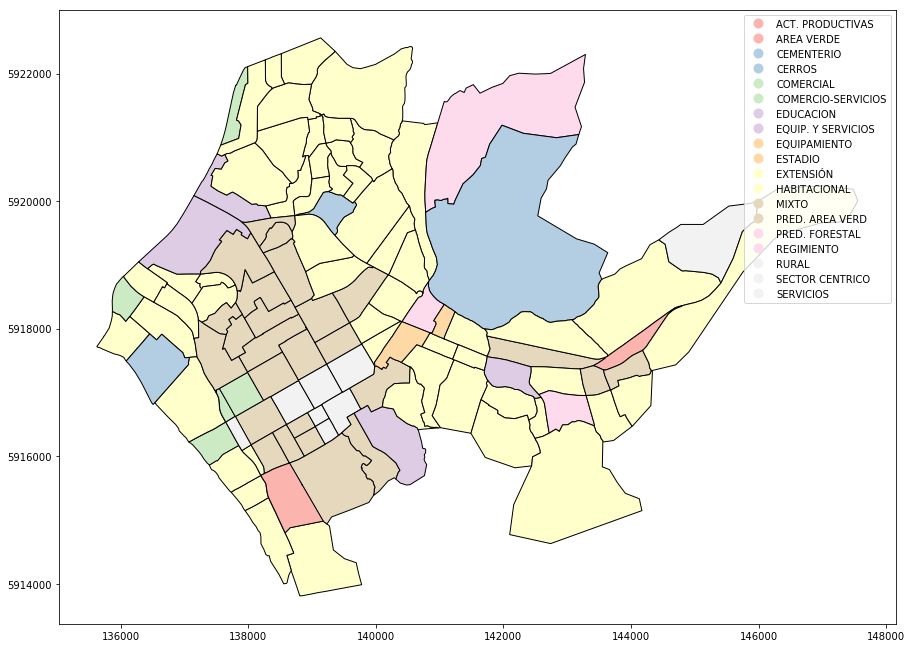

In [22]:
#Caracterización de uso de suelo en Concepción

GC.plot(cmap="Pastel1", column="CARACT", figsize=(15,20), edgecolor='black', legend=True)





In [23]:
# mi set de datos de demanda


heat_df[["Latitud", "Longitud"]] = heat_df[["Latitud", "Longitud"]].apply(pd.to_numeric) #transformar georeferencia a float


demanda_CCP = gpd.GeoDataFrame(heat_df, geometry=gpd.points_from_xy(heat_df.Longitud, heat_df.Latitud)) #crear nueva columna geometría para los puntos georeferenciados

L1 = len(demanda_CCP)
print("longiud de archivo antiguo:", L1) 
new_DCCP= pd.DataFrame(demanda_CCP) 
new_DCCP = demanda_CCP.dropna(axis = 0, how ='any') #Eliminar filas con valores nulos en las columnas evaluadas
L2 = len(demanda_CCP)
print("longitud de nuevo archivo:", L2)
print("filas con dato NaN eliminadas: ", (L1-L2))

new_DCCP = demanda_CCP

demanda_CCP = gpd.GeoDataFrame(new_DCCP, crs = {'init': 'epsg:4326'})  # Vuelvo a transformar a GeoDataframe y defino sistema inicial de coordenadas

demanda_CCP = demanda_CCP.to_crs({'init': 'epsg:32719'}) #Transformo sistema de coordenadas a Metrico para calzar con shape de CCP

#confirma la misma unidad de medida (sistema métrico para este caso)
print(demanda_CCP.crs)
print(GC.crs)


demanda_CCP["H_salida"] = heat_df.H_salida
demanda_CCP["H_llegada"] = heat_df.H_llegada


demanda_CCP.head(5)

longiud de archivo antiguo: 7507
longitud de nuevo archivo: 7507
filas con dato NaN eliminadas:  0
{'init': 'epsg:32719'}
{'init': 'epsg:32719'}


Latitud   Longitud  H_salida H_llegada  \
60 -36.828008 -73.048165   7:57:00   8:05:00   
76 -36.815459 -73.078526  11:00:00  11:20:00   
77 -36.828537 -73.056261  12:30:00  13:00:00   
80 -36.815459 -73.078526  10:00:00  10:01:00   
81 -36.815459 -73.078526  18:00:00  18:01:00   

                                       geometry  
60  POINT (138915.3521257266 5916553.519504989)  
76  POINT (136146.4157582288 5917831.207786838)  
77  POINT (138195.3672581275 5916464.115899885)  
80  POINT (136146.4157582288 5917831.207786838)  
81  POINT (136146.4157582288 5917831.207786838)

In [24]:
#seleccionar solo puntos de demanda (origen+destino) que tributan en el Gran Concepción

demand_B_CCP = gpd.sjoin(demanda_CCP, GC, op='intersects') 
#demand_B_CCP.plot(figsize=(10,10), cmap="inferno", edgecolor='black')

demand_B_CCP.head()

Latitud   Longitud  H_salida H_llegada  \
60   -36.828008 -73.048165   7:57:00   8:05:00   
152  -36.829860 -73.049384  17:00:00  17:07:00   
350  -36.828049 -73.048901  13:50:00  14:00:00   
1013 -36.827357 -73.048415  13:30:00  13:45:00   
1014 -36.827588 -73.048249   9:00:00   9:20:00   

                                         geometry  index_right  ZONA  \
60    POINT (138915.3521257266 5916553.519504989)           77   960   
152    POINT (138815.2938958766 5916343.31620694)           77   960   
350   POINT (138849.8652263751 5916546.181614585)           77   960   
1013   POINT (138889.976472612 5916624.839572761)           77   960   
1014  POINT (138905.8781349108 5916599.825064538)           77   960   

       macrozona  Shape_Area CARACT DETALLE  
60    Concepción    9.422917  MIXTO    None  
152   Concepción    9.422917  MIXTO    None  
350   Concepción    9.422917  MIXTO    None  
1013  Concepción    9.422917  MIXTO    None  
1014  Concepción    9.422917  MIXTO    None

El DF contiene  7496  entradas
se eliminaron  11  entradas outliers


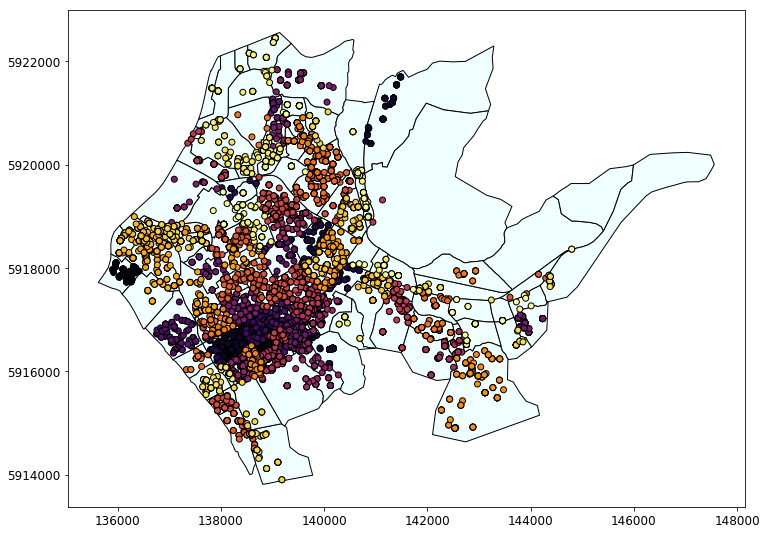

In [25]:
#Superponer datos de demanda sobre gráfico CCP
ax = GC.plot(color='azure', edgecolor='black', figsize=(15, 9.14))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
demand_B_CCP.plot(ax=ax, cmap="inferno", figsize=(15, 9.14), edgecolor='black')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig("demandaconce_total.png", bbox_inches="tight", dpi=300) 

print("El DF contiene ", len(demand_B_CCP), " entradas")
print("se eliminaron ", len(demanda_CCP)- len(demand_B_CCP), " entradas outliers")

In [26]:
demand_B_CCP

Latitud   Longitud  H_salida H_llegada  \
60    -36.828008 -73.048165   7:57:00   8:05:00   
152   -36.829860 -73.049384  17:00:00  17:07:00   
350   -36.828049 -73.048901  13:50:00  14:00:00   
1013  -36.827357 -73.048415  13:30:00  13:45:00   
1014  -36.827588 -73.048249   9:00:00   9:20:00   
1016  -36.827588 -73.048249   9:00:00   9:20:00   
1018  -36.827588 -73.048249  10:30:00  10:50:00   
1020  -36.827588 -73.048249   8:00:00   8:15:00   
1022  -36.827588 -73.048249  16:15:00  16:30:00   
1331  -36.827000 -73.048072  16:10:00  16:20:00   
1461  -36.828741 -73.049147  13:00:00  13:05:00   
1466  -36.828741 -73.049147  13:00:00  13:05:00   
1471  -36.828741 -73.049147  13:00:00  13:05:00   
1693  -36.828524 -73.051026   9:55:00  10:10:00   
1734  -36.827729 -73.049742  20:00:00  20:20:00   
1742  -36.827729 -73.049742  20:30:00  20:40:00   
1948  -36.829650 -73.049027  15:30:00  16:15:00   
1951  -36.828010 -73.050578  10:45:00  11:00:00   
4167  -36.827585 -73.049618  19:40:00  20:30:00   
4447  -36.829710 -73.050156  12:00:00  12:10:00   
4448  -36.828369 -73.048647  12:40:00  12:50:00   
4794  -36.828741 -73.049147  15:00:00  16:00:00   
6040  -36.828369 -73.048647  14:30:00  14:50:00   
6174  -36.828768 -73.050193  20:15:00  20:50:00   
6945  -36.828905 -73.049903  15:56:00  16:06:00   
9158  -36.828346 -73.048642   8:00:00   8:20:00   
9437  -36.828843 -73.049895  10:30:00  11:15:00   
10553 -36.828903 -73.049902  11:10:00  11:25:00   
10799 -36.828370 -73.048648   8:21:00   8:55:00   
10801 -36.828370 -73.048648  15:00:00  15:20:00   
...          ...        ...       ...       ...   
40623 -36.797440 -73.041486   9:00:00   9:30:00   
40625 -36.797440 -73.041486   9:00:00   9:30:00   
40627 -36.797440 -73.041486   7:45:00   8:10:00   
40629 -36.797440 -73.041486   7:45:00   8:10:00   
40631 -36.797440 -73.041486   7:45:00   8:10:00   
40633 -36.797440 -73.041486  14:20:00  15:00:00   
40635 -36.797440 -73.041486  17:00:00  17:10:00   
40637 -36.797440 -73.041486   8:10:00   8:15:00   
40639 -36.797440 -73.041486   8:00:00   8:25:00   
40641 -36.797440 -73.041486   8:30:00   8:40:00   
40642 -36.798528 -73.038535  12:00:00  12:10:00   
40643 -36.797440 -73.041486   8:00:00   8:30:00   
40645 -36.797440 -73.041486   7:30:00   8:00:00   
40647 -36.797440 -73.041486  10:00:00  10:30:00   
28302 -36.825895 -72.997172   7:30:00   7:35:00   
28304 -36.825895 -72.997172  12:50:00  13:00:00   
28308 -36.825895 -72.997172  15:00:00  16:00:00   
28310 -36.825895 -72.997172  15:00:00  16:00:00   
28312 -36.825895 -72.997172   9:00:00   9:05:00   
28314 -36.825895 -72.997172   8:00:00   8:30:00   
28316 -36.825895 -72.997172   7:30:00   8:00:00   
28318 -36.825895 -72.997172  13:00:00  13:10:00   
28320 -36.825895 -72.997172   7:30:00   8:00:00   
28322 -36.825895 -72.997172   8:00:00   8:15:00   
28324 -36.825895 -72.997172  10:00:00  10:10:00   
28326 -36.825895 -72.997172  15:50:00  16:00:00   
28332 -36.825895 -72.997172   8:00:00   8:15:00   
28334 -36.825895 -72.997172  12:00:00  12:20:00   
28309 -36.813954 -72.981549  20:00:00  21:00:00   
28311 -36.813954 -72.981549  20:00:00  21:00:00   

                                          geometry  index_right  ZONA  \
60     POINT (138915.3521257266 5916553.519504989)           77   960   
152     POINT (138815.2938958766 5916343.31620694)           77   960   
350    POINT (138849.8652263751 5916546.181614585)           77   960   
1013    POINT (138889.976472612 5916624.839572761)           77   960   
1014   POINT (138905.8781349108 5916599.825064538)           77   960   
1016   POINT (138905.8781349108 5916599.825064538)           77   960   
1018   POINT (138905.8781349108 5916599.825064538)           77   960   
1020   POINT (138905.8781349108 5916599.825064538)           77   960   
1022   POINT (138905.8781349108 5916599.825064538)           77   960   
1331   POINT (138918.9046386088 5916665.768114055)           77   960   
1461   POINT (138831.1720070368 5916468.432

#  Segmentación de instancias de prueba

en esta sección se segmenta la base de datos para dar camino a instancias de prueba que representan periodos acotados de tiempo en el que son emitidas las demandas por transporte

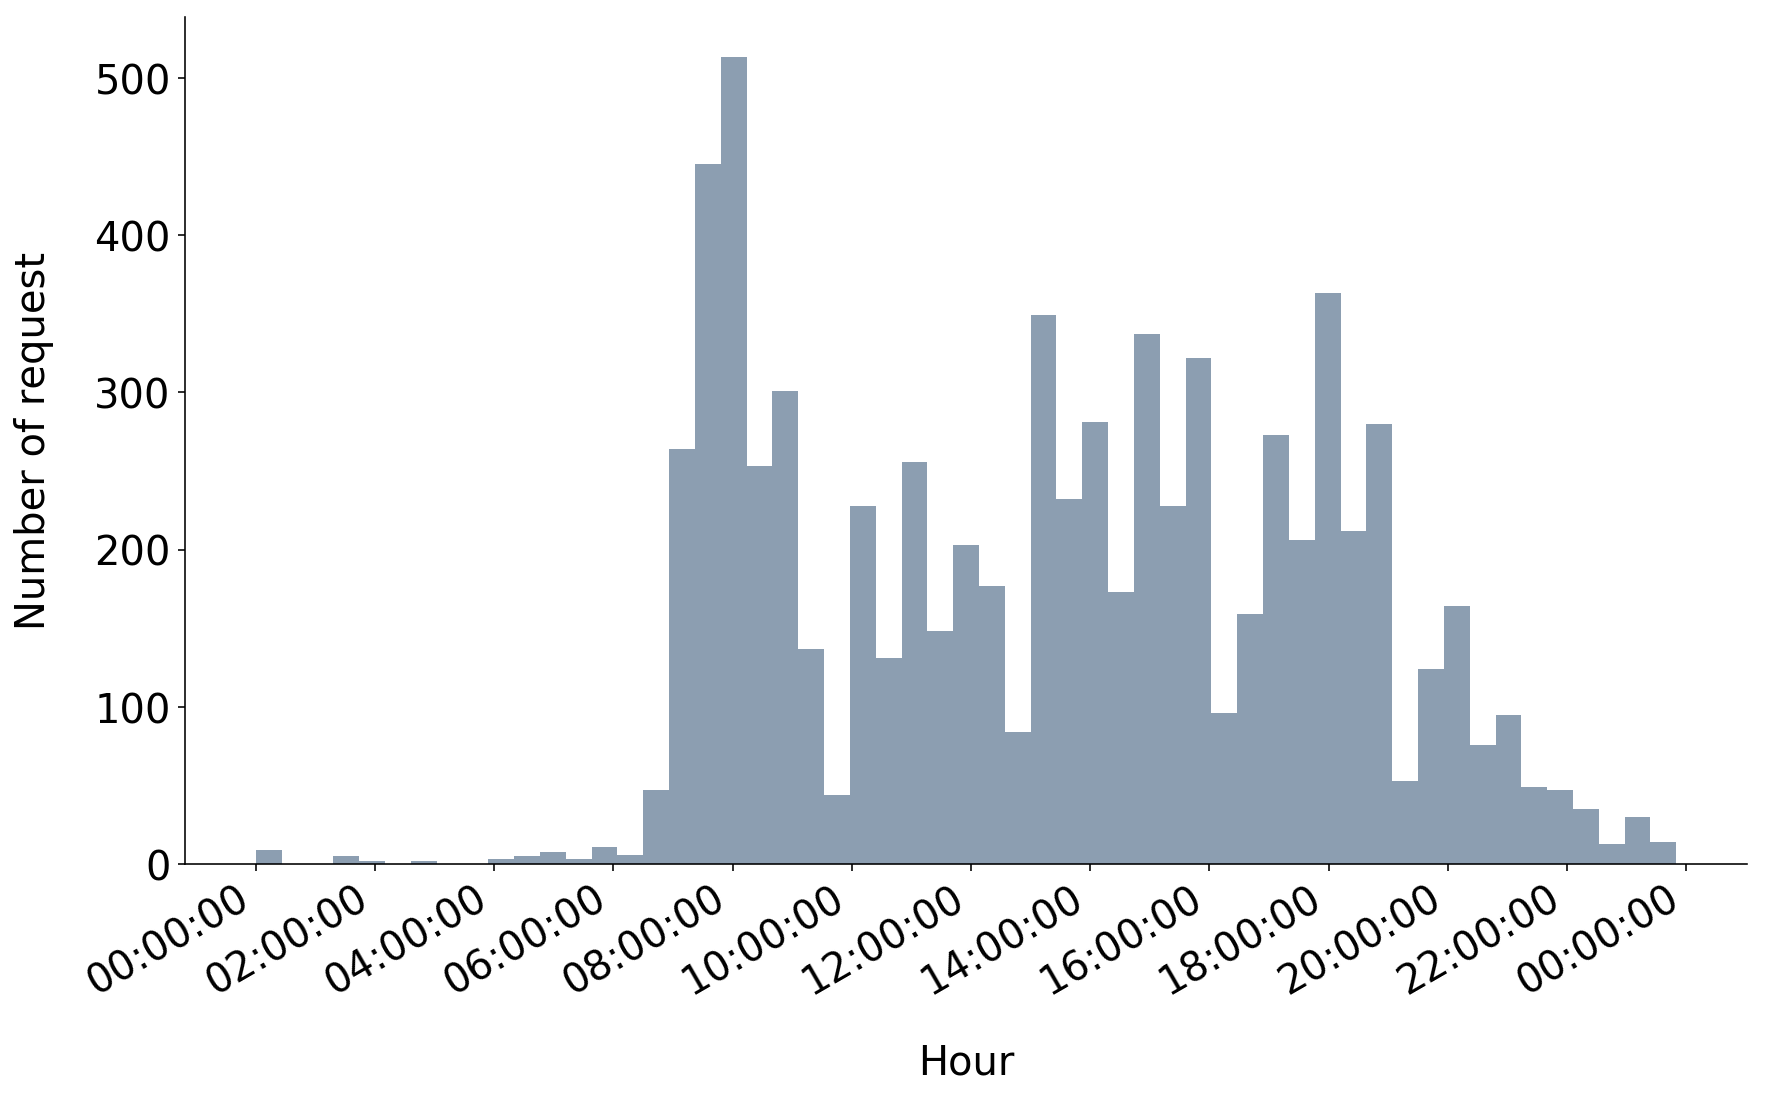

In [117]:
# Análisis Horas Peak  / Mayor demanda 

hs= pd.DataFrame()
hs["index"] = demand_B_CCP["H_salida"] #Creo una columna que servirá como index
hs["hora"] = pd.to_datetime(demand_B_CCP["H_salida"], infer_datetime_format=True) #transformo el string de hora a formato fecha
hs.set_index("index", drop=True, inplace=True) #señalo a la columna index como índice del set de datos
hs.dropna(inplace=True) # elimino datos sin horario informado



%config InlineBackend.figure_format = 'retina'


    
# Gráfico

plt.figure(figsize=(14,8.65))

ax = plt.subplot(111)
ax.spines["top"].set_visible(False)    
#ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
#ax.spines["left"].set_visible(False)  

plt.xticks( fontsize=20)  
plt.yticks(fontsize=20)  

ax.set_ylabel("Number of request", fontsize=20, labelpad=20)
ax.set_xlabel("Hour", fontsize=20, labelpad=20)

plt.hist(hs["hora"], color="#3F5D7D", bins=55, density=False, histtype="bar", alpha=0.6)
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

plt.gcf().autofmt_xdate()

#ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.axis('tight')


plt.savefig("distribuciontemporal.png", bbox_inches="tight", dpi=300) 
plt.show()




In [28]:
#se observan dos peaks diarios de demanda:  cerca de las 8:00 y 18:00 horas 

demand_B_CCP["hora"] = pd.to_datetime(demand_B_CCP["H_salida"], infer_datetime_format=True)

demand_B_CCP.head()


Latitud   Longitud  H_salida H_llegada  \
60   -36.828008 -73.048165   7:57:00   8:05:00   
152  -36.829860 -73.049384  17:00:00  17:07:00   
350  -36.828049 -73.048901  13:50:00  14:00:00   
1013 -36.827357 -73.048415  13:30:00  13:45:00   
1014 -36.827588 -73.048249   9:00:00   9:20:00   

                                         geometry  index_right  ZONA  \
60    POINT (138915.3521257266 5916553.519504989)           77   960   
152    POINT (138815.2938958766 5916343.31620694)           77   960   
350   POINT (138849.8652263751 5916546.181614585)           77   960   
1013   POINT (138889.976472612 5916624.839572761)           77   960   
1014  POINT (138905.8781349108 5916599.825064538)           77   960   

       macrozona  Shape_Area CARACT DETALLE                hora  
60    Concepción    9.422917  MIXTO    None 2021-01-03 07:57:00  
152   Concepción    9.422917  MIXTO    None 2021-01-03 17:00:00  
350   Concepción    9.422917  MIXTO    None 2021-01-03 13:50:00  
1013  Concepción    9.422917  MIXTO    None 2021-01-03 13:30:00  
1014  Concepción    9.422917  MIXTO    None 2021-01-03 09:00:00

In [29]:
#FILRTANDO valores por hora  // instancia IN02

print("El DF original contiene ", len(demand_B_CCP), " entradas")


Hora_Peak = demand_B_CCP.hora.between("17:58:00","19:00:00", inclusive=False)
HP = demand_B_CCP[Hora_Peak]
#HP.dropna(inplace=True)
print("El DF HP contiene ", len(HP), " entradas")

PM2100 = demand_B_CCP.hora == "21:00:00"
PM21 = demand_B_CCP[PM2100]
#PM21.dropna(inplace = True)
print ( "El DF PM22 contiene ", len(PM21), " entradas")

'''
otras horas peak
'''
AM8000 = demand_B_CCP.hora == "8:00:00"
AM8 = demand_B_CCP[AM8000]
#AM8.dropna(inplace = True)
print("El DF AM8 contiene ", len(AM8), " entradas")


AM7000 = demand_B_CCP.hora == "7:00:00"
AM7 = demand_B_CCP[AM7000]
#AM7.dropna(inplace = True)
print("El DF AM7 contiene ", len(AM7), " entradas")

AM6000 = demand_B_CCP.hora == "6:00:00"
AM6 = demand_B_CCP[AM6000]
#AM6.dropna(inplace = True)
print("El DF AM6 contiene ", len(AM6), " entradas")

'''
Rangos de horas 
'''


Post_17 = demand_B_CCP.hora.between("17:00:00","23:59:00", inclusive=True)
Post_17 = demand_B_CCP[Post_17]
#Post_17.dropna(inplace = True)
#Post_17 = gpd.sjoin(Post_17, GC, op='intersects')

print("El DF Post_17 contiene ", len(Post_17), " entradas")

Pre_8 = demand_B_CCP.hora.between("00:00:00","9:00:00", inclusive=False)
Pre_8 = demand_B_CCP[Pre_8]
#Pre_8.dropna(inplace = True)
#Pre_8 = gpd.sjoin(Pre_8, GC, op='intersects')
print("El DF Pre_8 contiene ", len(Pre_8), " entradas")




El DF original contiene  7496  entradas
El DF HP contiene  623  entradas
El DF PM22 contiene  87  entradas
El DF AM8 contiene  279  entradas
El DF AM7 contiene  122  entradas
El DF AM6 contiene  10  entradas
El DF Post_17 contiene  2025  entradas
El DF Pre_8 contiene  1652  entradas


In [30]:
Post_17.head()

Latitud   Longitud  H_salida H_llegada  \
152  -36.829860 -73.049384  17:00:00  17:07:00   
1734 -36.827729 -73.049742  20:00:00  20:20:00   
1742 -36.827729 -73.049742  20:30:00  20:40:00   
4167 -36.827585 -73.049618  19:40:00  20:30:00   
6174 -36.828768 -73.050193  20:15:00  20:50:00   

                                         geometry  index_right  ZONA  \
152    POINT (138815.2938958766 5916343.31620694)           77   960   
1734  POINT (138773.3075873479 5916578.519645615)           77   960   
1742  POINT (138773.3075873479 5916578.519645615)           77   960   
4167  POINT (138783.6949200668 5916594.974478612)           77   960   
6174  POINT (138737.9559329513 5916461.473632051)           77   960   

       macrozona  Shape_Area CARACT DETALLE                hora  
152   Concepción    9.422917  MIXTO    None 2021-01-03 17:00:00  
1734  Concepción    9.422917  MIXTO    None 2021-01-03 20:00:00  
1742  Concepción    9.422917  MIXTO    None 2021-01-03 20:30:00  
4167  Concepción    9.422917  MIXTO    None 2021-01-03 19:40:00  
6174  Concepción    9.422917  MIXTO    None 2021-01-03 20:15:00

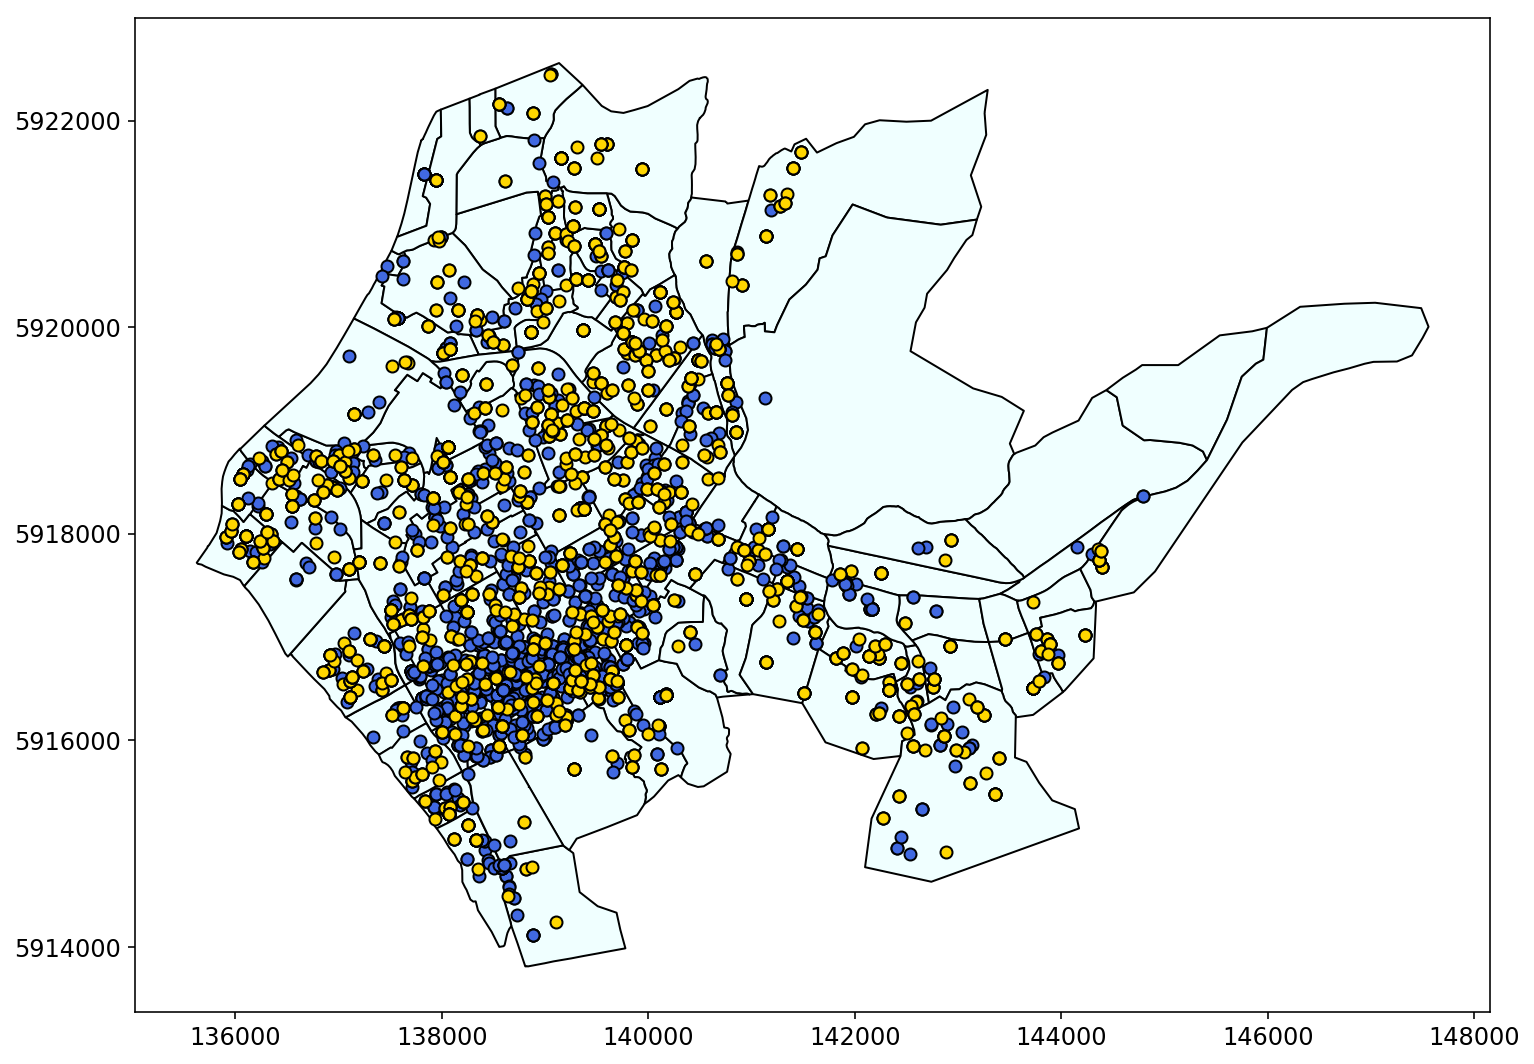

In [31]:
ax = GC.plot(color='azure', edgecolor='black', figsize=(15,9.14))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#HP.plot(ax=ax, cmap="inferno", figsize=(15,9.14), edgecolor='black')
Post_17.plot(ax=ax, color="royalblue", figsize=(15,9.14), edgecolor='black')
#HP.plot(ax=ax, color="tomato", figsize=(15,9.14), edgecolor='black')
Pre_8.plot(ax=ax, color="gold", figsize=(15,9.14), edgecolor='black')
#AM6.plot(ax=ax, color="yellow", figsize=(15,9.14), edgecolor='black')
#AM8.plot(ax=ax, color="yellow", figsize=(15,9.14), edgecolor='black')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig("demanda18hrs_vs_8AM.png", bbox_inches="tight", format="png", dpi=300)


In [32]:
# Construyendo Heatmap para datos filtrados

print(len(HP))
hm_HP = pd.DataFrame()


hm_HP['Latitud'] = HP['Latitud'].astype(float)
hm_HP['Longitud'] = HP['Longitud'].astype(float)

# generar una lista de lista
hm_HP = [[row['Latitud'],row['Longitud']] for index, row in hm_HP.iterrows()]

base_map = generateBaseMap()
HeatMap(hm_HP, radius=8, max_zoom=15).add_to(base_map)

print(len(hm_HP))


623
623


In [33]:
base_map

# Evaluación de Zonas de mayor demanda

En esta sección se analiza la demanda de transporte y se georeferencian las estaciones de alta demanda


In [34]:
# Estas zonas se podrían convertir en Potenciales estaciones flotantes 

EP = pd.read_csv(r'C:\Users\croja\Tesiss/Potenciales_estaciones_CCP.csv', sep = ';', encoding='latin-1')

EP = gpd.GeoDataFrame(EP, crs = {'init': 'epsg:4326'}, geometry=gpd.points_from_xy(EP.Longitud.astype(float), EP.Latitud.astype(float)))

print(len(EP))
EP.head(26)



25


Lugar    Latitud   Longitud  \
0                                      Plaza Espana -36.829800 -73.058626   
1                           Copec Prat con cochrane -36.832622 -73.057319   
2                                  Angol con Barros -36.828374 -73.054727   
3                               Mall Mirador Biobio -36.830845 -73.062758   
4                     Pedro del Rio Cancha frontera -36.825954 -73.068595   
5                                Rengo con Ohiggins -36.828360 -73.051556   
6                                    Plaza de Armas -36.827332 -73.050086   
7                                Rengo con Cochrane -36.830279 -73.050761   
8                       San Martin con Anibal Pinto -36.828233 -73.048540   
9                           Caupolican con Carreras -36.823857 -73.052962   
10                                       Tribunales -36.825457 -73.046718   
11                      Victor Lamas con Caupolican -36.832521 -73.047499   
12                                 Sanatorio Aleman -36.843781 -73.055941   
13                                  Mall del Centro -36.824431 -73.045116   
14                                       Plaza Peru -36.826891 -73.039995   
15                        Universidad de Concepcion -36.826804 -73.038518   
16                            Juan Bosco Salesianos -36.818542 -73.034267   
17                        Universidad San Sebastian -36.814558 -73.047057   
18                                    Hospital ACHS -36.820529 -73.031801   
19                           Universidad del BioBio -36.820529 -73.014949   
20                    Terminal de Buses con Estadio -36.816621 -73.024552   
21                               Poblacion Andalien -36.800271 -73.026174   
22                                  Vega Monumental -36.808165 -73.078325   
23  Universidad Catolica de la Santísima Concepcion -36.799007 -73.054756   
24                              Freire con Janequeo -36.821495 -73.041467   

                                 geometry  
0             POINT (-73.058626 -36.8298)  
1   POINT (-73.05731899999999 -36.832622)  
2           POINT (-73.054727 -36.828374)  
3           POINT (-73.062758 -36.830845)  
4           POINT (-73.068595 -36.825954)  
5    POINT (-73.05155600000001 -36.82836)  
6   POINT (-73.05008599999999 -36.827332)  
7   POINT (-73.05076099999999 -36.830279)  
8            POINT (-73.04854 -36.828233)  
9   POINT (-73.05296199999999 -36.823857)  
10          POINT (-73.046718 -36.825457)  
11          POINT (-73.047499 -36.832521)  
12          POINT (-73.055941 -36.843781)  
13  POINT (-73.04511600000001 -36.824431)  
14  POINT (-73.03999499999999 -36.826891)  
15  POINT (-73.03851800000001 -36.826804)  
16          POINT (-73.034267 -36.818542)  
17          POINT (-73.047057 -36.814558)  
18          POINT (-73.031801 -36.820529)  
19          POINT (-73.014949 -36.820529)  
20          POINT (-73.024552 -36.816621)  
21          POINT (-73.026174 -36.800271)  
22  POINT (-73.07832500000001 -36.808165)  
23  POINT (-73.05475600000001 -36.799007)  
24          POINT (-73.041467 -36.821495)

In [35]:
EP_M = EP.to_crs({'init': 'epsg:32719'}) #Transformo sistema de coordenadas a Metrico df EP
GC_G = GC.to_crs({"init": 'epsg:4326' }) #Transformo sistema MEtrico a coordenadas df GC 
HP_G = HP.to_crs({"init": 'epsg:4326' })

#confirma  unidad de medida del sistema métrico de cada GeoData Frame

print(EP.crs)
print(EP_M.crs)
print(GC.crs)
print(GC_G.crs)
print(HP.crs)
print(HP_G.crs)
#EP_M.head()
EP.head()

{'init': 'epsg:4326'}
{'init': 'epsg:32719'}
{'init': 'epsg:32719'}
{'init': 'epsg:4326'}
{'init': 'epsg:32719'}
{'init': 'epsg:4326'}


Lugar    Latitud   Longitud  \
0                   Plaza Espana -36.829800 -73.058626   
1        Copec Prat con cochrane -36.832622 -73.057319   
2               Angol con Barros -36.828374 -73.054727   
3            Mall Mirador Biobio -36.830845 -73.062758   
4  Pedro del Rio Cancha frontera -36.825954 -73.068595   

                                geometry  
0            POINT (-73.058626 -36.8298)  
1  POINT (-73.05731899999999 -36.832622)  
2          POINT (-73.054727 -36.828374)  
3          POINT (-73.062758 -36.830845)  
4          POINT (-73.068595 -36.825954)

In [36]:
#Bases para tomar la medicion de distancia

Base_1 = EP

Base_2 = HP_G

print(Base_1.crs)
print(Base_2.crs)

# Descompongo el objeto coordenadas de ambas bases

Base_1['x'] = Base_1.geometry.centroid.x.astype(float)
Base_1['y'] = Base_1.geometry.centroid.y.astype(float)

Base_2['x'] = Base_2.geometry.centroid.x.astype(float)
Base_2['y'] = Base_2.geometry.centroid.y.astype(float)

Base_2.head()

{'init': 'epsg:4326'}
{'init': 'epsg:4326'}


Latitud   Longitud  H_salida H_llegada  \
13145 -36.829685 -73.049073  18:00:00  18:15:00   
17374 -36.829091 -73.050614  18:30:00  18:50:00   
19143 -36.828903 -73.049901  18:45:00  19:00:00   
19375 -36.826884 -73.047994  18:00:00  18:10:00   
19379 -36.826884 -73.047994  18:30:00  18:45:00   

                                     geometry  index_right  ZONA   macrozona  \
13145   POINT (-73.04907300000001 -36.829685)           77   960  Concepción   
17374   POINT (-73.050614 -36.82909099999999)           77   960  Concepción   
19143   POINT (-73.04990100000001 -36.828903)           77   960  Concepción   
19375  POINT (-73.0479943 -36.82688419999999)           77   960  Concepción   
19379  POINT (-73.0479943 -36.82688419999999)           77   960  Concepción   

       Shape_Area CARACT DETALLE                hora          x          y  
13145    9.422917  MIXTO    None 2021-01-03 18:00:00 -73.049073 -36.829685  
17374    9.422917  MIXTO    None 2021-01-03 18:30:00 -73.050614 -36.829091  
19143    9.422917  MIXTO    None 2021-01-03 18:45:00 -73.049901 -36.828903  
19375    9.422917  MIXTO    None 2021-01-03 18:00:00 -73.047994 -36.826884  
19379    9.422917  MIXTO    None 2021-01-03 18:30:00 -73.047994 -36.826884

In [37]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculo de distancia basado en fórmula Harvesine. Entrega la distancia en kilometros
    """
    # Convierte loaclización a radianes 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radio de la tierra en Km
    d = c * r
    return round(d,2)








In [38]:
#Calculo de distancia entre dos puntos. 

x1 = Base_1.x[0]
y1 = Base_1.y[0]

x2 = Base_2.iloc[0][-2]
y2 = Base_2.iloc[0][-1]

#x1, y1, x2, y2

haversine(x1, y1, x2, y2)

0.85

In [39]:
#calculo distancia desde todos los puntos de un DF a un solo punto

distancias = []
for i in range(len(Base_2)):
    x2 = Base_2.iloc[i][-2]
    y2 = Base_2.iloc[i][-1]
    distancias.append(haversine(x1, y1, x2, y2))

distancias = pd.DataFrame(distancias)

distancias.describe()




0
count  623.000000
mean     1.907448
std      1.351809
min      0.040000
25%      0.810000
50%      1.620000
75%      2.710000
max      6.230000

C:\Users\croja\Anaconda3\lib\site-packages\geopandas\plotting.py:471: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


<Figure size 432x288 with 0 Axes>

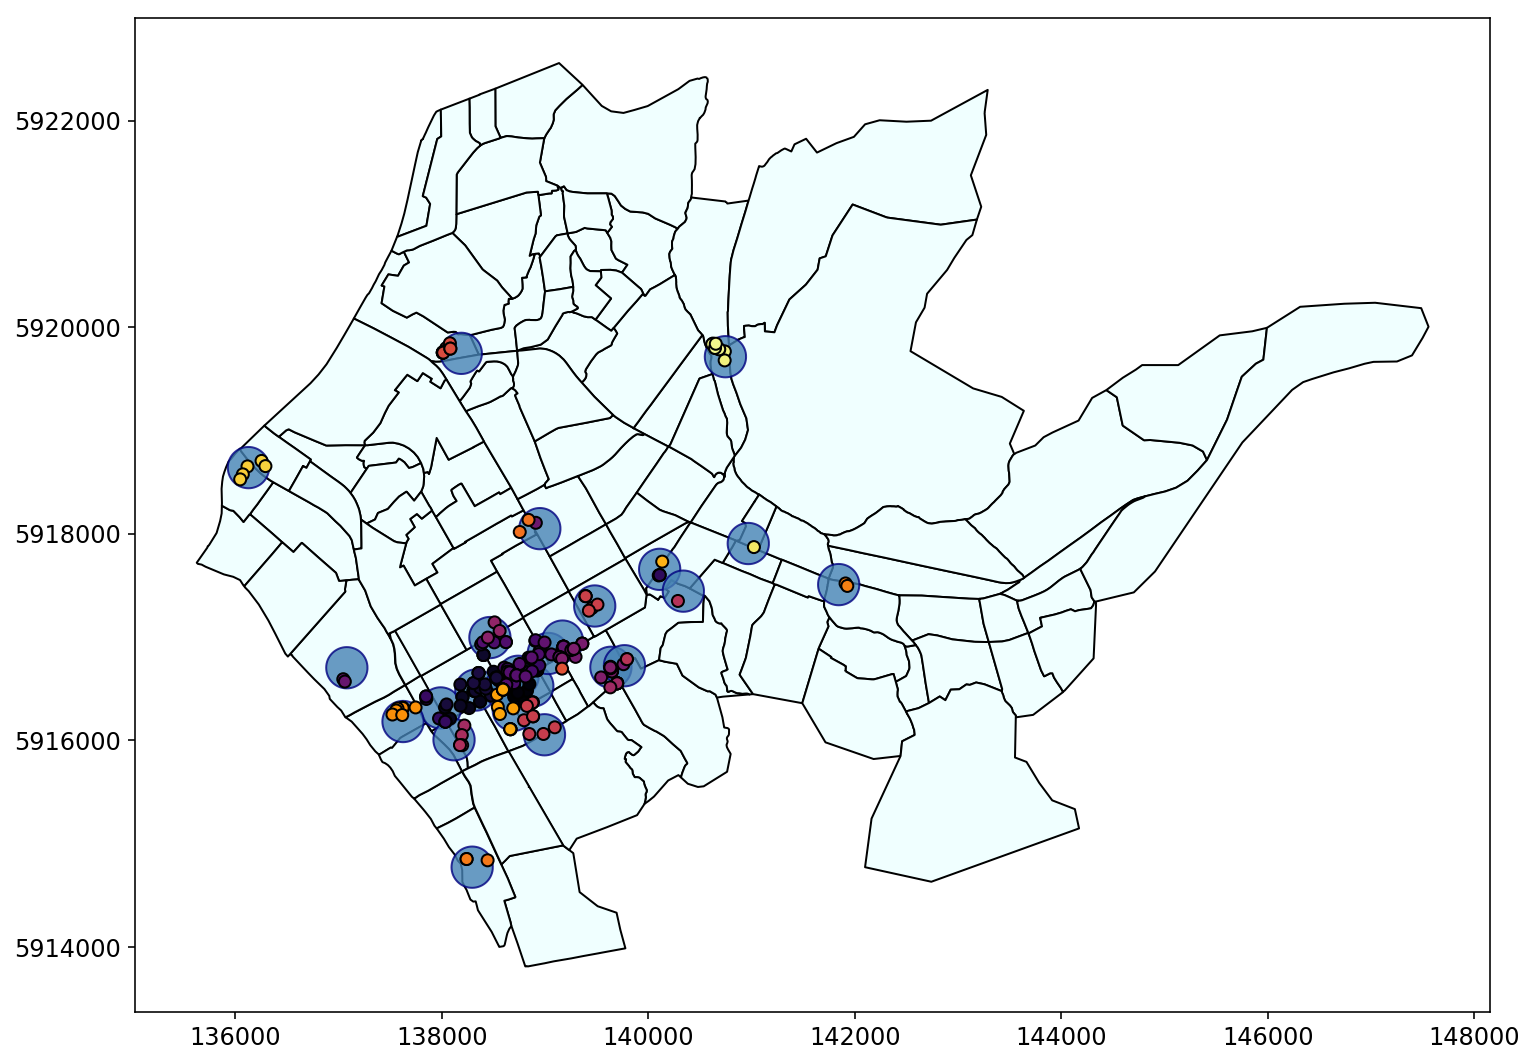

In [40]:
# Determinación cobertura de estaciones

HP_EP = HP.copy()

EP = pd.read_csv(r'C:\Users\croja\Tesiss/Potenciales_estaciones_CCP.csv', sep = ';', encoding='latin-1')

rdf_EP= gpd.GeoDataFrame(EP, geometry=gpd.points_from_xy(EP.Longitud, EP.Latitud), crs = {'init': 'epsg:4326'}) 

rdf2_EP = rdf_EP.to_crs({'init': 'epsg:32719'})

radioEP_0 = rdf2_EP.buffer(200) #radios paradas
radioEP_1 = rdf2_EP.buffer(200).unary_union  #multipolígono paradas


paradas_EP = HP_EP['geometry'].intersection(radioEP_1) # Intersección puntos demanda con 


plt.figure()

ax = GC.plot(color="azure", column="CARACT", figsize=(15,9.14), edgecolor='black', legend=False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
radioEP_0.plot(ax=ax, color="steelblue", edgecolor="navy", figsize=(15,9.14), alpha=0.8)
paradas_EP.plot(ax=ax, cmap="inferno", figsize=(15,9.14), edgecolor='black')



plt.savefig("Demanda_en_Paradas.png", bbox_inches="tight", format="png", dpi=300)


In [41]:
Demand_Paradas_EP = HP_EP[~paradas_EP.is_empty]

print("demanda total: ", str(HP_EP.shape[0]), "solicitudes")
print("demanda en el radio de paradas: " + str(Demand_Paradas_EP.shape[0]))

print("Las paradas de alta demanda albergan directamente el ", round((len(Demand_Paradas_EP))*100/(len(HP)), 2), "% de las demandas solicitadas a las 18:00 hrs.")
print("Sin embargo, el ", (round(100-(len(Demand_Paradas_EP))*100/(len(HP)), 2)), "% de las potenciales demandas restantes no son atendidas y requieren relocalización")

demanda total:  623 solicitudes
demanda en el radio de paradas: 232
Las paradas de alta demanda albergan directamente el  37.24 % de las demandas solicitadas a las 18:00 hrs.
Sin embargo, el  62.76 % de las potenciales demandas restantes no son atendidas y requieren relocalización



# Construcción de Instancias


En esta sección se prepara la información obtenida desde la base de datos para que pueda ser conducida hacia el modelo matemático

In [42]:
IN01_in = demand_B_CCP.copy() # toda la demanda que entra y sale desde el GRAN CONCEPCIÓN

IN01_in['x'] = IN01_in.geometry.centroid.x.astype(float)
IN01_in['y'] = IN01_in.geometry.centroid.y.astype(float)

IN01 = IN01_in.sample(frac=0.6, replace=True, random_state=1)  #tomo aleatoriamente el 60% de los datos como muestra

points_01 = list(zip(IN01.x, IN01.y))

df_IN01= pd.DataFrame(points_01, columns=["x", "y"])

dist_Mtrx_01 = pd.DataFrame(distance_matrix(df_IN01.values.astype(int), df_IN01.values.astype(int)), index=df_IN01.index, columns=df_IN01.index)

DM_01 = dist_Mtrx_01.stack().values.astype(int)

with open('DM_01.txt', 'w') as file:   #secuencia en una lista ordenada la matriz de distancia 
    for i in DM_01:
        file.write(str(i) + '\n')

print(len(IN01))
#IN01.head(5)


4498


In [43]:
IN01.info(memory_usage="deep")


<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4498 entries, 33562 to 17691
Data columns (total 14 columns):
Latitud        4498 non-null float64
Longitud       4498 non-null float64
H_salida       4498 non-null object
H_llegada      4498 non-null object
geometry       4498 non-null geometry
index_right    4498 non-null int64
ZONA           4498 non-null int64
macrozona      4498 non-null object
Shape_Area     4498 non-null float64
CARACT         4498 non-null object
DETALLE        0 non-null object
hora           4498 non-null datetime64[ns]
x              4498 non-null float64
y              4498 non-null float64
dtypes: datetime64[ns](1), float64(5), geometry(1), int64(2), object(5)
memory usage: 1.7 MB


In [44]:
IN02 = HP.copy()   #Tomo solo datos de demanda a las 18:00 hrs

IN02['x'] = IN02.geometry.centroid.x.astype(float)
IN02['y'] = IN02.geometry.centroid.y.astype(float)

points_02 = list(zip(IN02.x, IN02.y))

df_IN02= pd.DataFrame(points_02, columns=["x", "y"])

dist_Mtrx_02 = pd.DataFrame(distance_matrix(df_IN02.values.astype(int), df_IN02.values.astype(int)), index=df_IN02.index, columns=df_IN02.index)

DM_02 = dist_Mtrx_02.stack().values.astype(int)

with open('DM_02.txt', 'w') as file:   #secuencia en una lista ordenada la matriz de distancia 
    for i in DM_02:
        file.write(str(i) + '\n')
        
print(len(IN02))
#IN02.head(5)

623


In [45]:
IN03_in = HP.copy()

IN03_in['x'] = IN03_in.geometry.centroid.x.astype(float)
IN03_in['y'] = IN03_in.geometry.centroid.y.astype(float)

IN03 = IN03_in.sample(frac=0.2, replace=True, random_state=1)  #tomo el 20% de los datos que ocurren post 17:00 como muestra

points_03 = list(zip(IN03.x, IN03.y))

df_IN03= pd.DataFrame(points_03, columns=["x", "y"])

dist_Mtrx_03 = pd.DataFrame(distance_matrix(df_IN03.values.astype(int), df_IN03.values.astype(int)), index=df_IN03.index, columns=df_IN03.index)

DM_03 = dist_Mtrx_03.stack().values.astype(int)

with open('DM_03.txt', 'w') as file:   #secuencia en una lista ordenada la matriz de distancia 
    for i in DM_03:
        file.write(str(i) + '\n')
        

print(len(IN03))




125


In [122]:
IN04 = Post_17.copy()  # Demanda post 17:00 hrs

IN04_cplx = IN04.sample(frac=0.5, replace=True, random_state=1)


IN04['x'] = IN04.geometry.centroid.x.astype(float)
IN04['y'] = IN04.geometry.centroid.y.astype(float)

IN04_cplx['x'] = IN04_cplx.geometry.centroid.x.astype(float)
IN04_cplx['y'] = IN04_cplx.geometry.centroid.y.astype(float)

points_04 = list(zip(IN04.x, IN04.y))
points_04_2 = list(zip(IN04_cplx.x, IN04_cplx.y))

df_IN04= pd.DataFrame(points_04, columns=["x", "y"])
df_IN04_2= pd.DataFrame(points_04_2, columns=["x", "y"])

dist_Mtrx_04 = pd.DataFrame(distance_matrix(df_IN04.values.astype(int), df_IN04.values.astype(int)), index=df_IN04.index, columns=df_IN04.index)
dist_Mtrx_04_2 = pd.DataFrame(distance_matrix(df_IN04_2.values.astype(int), df_IN04_2.values.astype(int)), index=df_IN04_2.index, columns=df_IN04_2.index)

DM_04 = dist_Mtrx_04.stack().values.astype(int)
DM_04_2 = dist_Mtrx_04_2.stack().values.astype(int)

with open('DM_04.txt', 'w') as file:   #secuencia en una lista ordenada la matriz de distancia 
    for i in DM_04:
        file.write(str(i) + '\n')
        
print(len(IN05))
print(len(IN04_cplx))
#IN04.head(5)

1652
1012


In [121]:
IN05 = Pre_8.copy()  # Demanda pre 08:00 hrs

IN05_cplx = IN05.sample(frac=0.5, replace=True, random_state=1)


IN05['x'] = IN05.geometry.centroid.x.astype(float)
IN05['y'] = IN05.geometry.centroid.y.astype(float)

IN05_cplx['x'] = IN05_cplx.geometry.centroid.x.astype(float)
IN05_cplx['y'] = IN05_cplx.geometry.centroid.y.astype(float)

points_05 = list(zip(IN05.x, IN05.y))
points_05_2 = list(zip(IN05_cplx.x, IN05_cplx.y))

df_IN05= pd.DataFrame(points_05, columns=["x", "y"])
df_IN05_2= pd.DataFrame(points_05_2, columns=["x", "y"])

dist_Mtrx_05 = pd.DataFrame(distance_matrix(df_IN05.values.astype(int), df_IN05.values.astype(int)), index=df_IN05.index, columns=df_IN05.index)
dist_Mtrx_05_2 = pd.DataFrame(distance_matrix(df_IN05_2.values.astype(int), df_IN05_2.values.astype(int)), index=df_IN05_2.index, columns=df_IN05_2.index)

DM_05 = dist_Mtrx_05.stack().values.astype(int)
DM_05_2 = dist_Mtrx_05_2.stack().values.astype(int)

with open('DM_05.txt', 'w') as file:   #secuencia en una lista ordenada la matriz de distancia 
    for i in DM_05:
        file.write(str(i) + '\n')
        
print(len(IN05))
print(len(IN05_cplx))
#IN04.head(5)

1652
826


In [66]:
N = 20
#np.random.seed(1)
demanda = np.random.randint(31, size=(N,N))
x1 = np.random.randint(2, size = (N,N))
x2 = np.random.randint(31)
#x1 = np.fromfunction(lambda i,  j : i*1, (N,N)).astype(int)

#print(demanda)
print(x2)


        
    
"""
    #Restricción: demanda no sobrepasa Capacidad
    dem = [None]*p
    for i in range(p):
        dem[i] = [None]*p
        for j in range(p):
            dema = np.random.randint(31)
            dem[i][j] = m.iif(x[j], dema, 0)
           
    m.constraint(dem[i][j] <= Q) 
    
 """




30


'\n    #Restricción: demanda no sobrepasa Capacidad\n    dem = [None]*p\n    for i in range(p):\n        dem[i] = [None]*p\n        for j in range(p):\n            dema = np.random.randint(31)\n            dem[i][j] = m.iif(x[j], dema, 0)\n           \n    m.constraint(dem[i][j] <= Q) \n    \n '

# Resolución problema de localizacíón/relocalización 

En esta sección se modela la resolución del problema mediante un modelo matemático basado en la determinación de p-medianas para un escenario estático de tiempo-espacio

In [131]:
def prep_instancia(filename):
    with open(filename) as f:
        return [int(elem) for elem in f.read().split()]

#filename= r"C:\Users\croja\Downloads\pmedian\pmedian\instances/pmed25.in"
file=r"C:\Users\croja\Tesiss/DM_04.txt"


if len(sys.argv) < 2:
    print ("Usage: python pmedian.py inputFile [outputFile] [timeLimit]")
    sys.exit(1)

with localsolver.LocalSolver() as ls:

    #
    # Leer Instancia
    #

    file_it = iter(prep_instancia(file))
    # Número de nodos de demanda 
    N = len(IN04)
    # Número de arcos 
    E = len(DM_04)-N
    # Cantidad de HUBS abiertos
    p = 40
    #Capacidad máxima de cada mediana
    Q = 30
    #Demanda estimada de cada nodo
    
    

    # w: Matriz de distancia de los tramos más cortos entre nodos 
    # wmax: Distancia máxima entre dos nodos
    wmax = 0
    w = [None]*N
    for i in range(N):
        w[i] = [None]*N
        for j in range(N):
            w[i][j] = next(file_it)
            if w[i][j] > wmax:
                wmax = w[i][j]

    #
    # Declarar modelo de optimización
    #
    m = ls.model

    # Variables de decisión 
    # x: matriz de localización; 1 si se designa una mediana, 0 si no
    x = [m.bool() for i in range(N)]

    # Restricción: no más de p locaciones son seleccionadas 
    p_HUBs = m.sum(x[i] for i in range(N))
    m.constraint(p_HUBs <= p)
    
    

    # Costo entre nodo i y j es w[i][j] si j está seleccionado como HUB, o 2*wmax si no lo está
    costs = [None]*N
    for i in range(N):
        costs[i] = [None]*N
        for j in range(N):
            costs[i][j] = m.iif(x[j], w[i][j], 2*wmax)
            

    # Costo entre nodo i y el HUB más cercano
    cost = [None]*N
    for i in range(N):
        cost[i] = m.min(costs[i][j] for j in range(N))
  
        
        
    # Minimizar costo total
    total_cost = m.sum(cost[i] for i in range(N))
    m.minimize(total_cost)  

    m.close()
    
    
    #
    # Parametrización del solver
    #
    if len(sys.argv) >= 4: ls.param.time_limit = int(sys.argv[3])
    else: ls.param.time_limit = 600

    ls.solve()

    #
    # Presentación de la información. Se entregan rsultados del modelo en el siguiente orden:
    # - Valor del Objetivo / %GAP 
    # - indices de los HUBS seleccionados (Entre 0 y N-1) */
    # - 
    
            
    if len(sys.argv) >= 3:
        with open('reporte_IN04_40nodes.csv', 'w') as f:   #exportación reporte
            f.write("%d\n" % total_cost.value)
            for i in range(N):
                if x[i].value == 1:
                    f.write("%d\n" % i)
            f.write("\n")
        print("\n")
        print("P-HUBS: ")    
        for i in range(N):
            if x[i].value == 1:
                    print("%d " % i )
                    
            
       
    

Push initial solutions 100%
Model:  expressions = 4112551, decisions = 2025, constraints = 1, objectives = 1
Param:  time limit = 600 sec, no iteration limit

[objective direction ]:     minimize

[  0 sec,       0 itr]:  3.59681e+07
[ optimality gap     ]:         100%
[  1 sec,      67 itr]:       652792
[  2 sec,     427 itr]:       520560
[  3 sec,     751 itr]:       502276
[  4 sec,    1110 itr]:       492770
[  5 sec,    1431 itr]:       489602
[  6 sec,    1715 itr]:       480332
[  7 sec,    2026 itr]:       479167
[  8 sec,    2276 itr]:       478523
[  9 sec,    2553 itr]:       476957
[ 10 sec,    2774 itr]:       473515
[ optimality gap     ]:         100%
[ 11 sec,    2970 itr]:       467397
[ 12 sec,    3203 itr]:       467067
[ 13 sec,    3464 itr]:       465830
[ 14 sec,    3726 itr]:       462944
[ 15 sec,    3993 itr]:       462944
[ 16 sec,    4226 itr]:       462014
[ 17 sec,    4438 itr]:       455803
[ 18 sec,    4681 itr]:       455244
[ 19 sec,    4947 itr]:   

[196 sec,   43875 itr]:       434287
[197 sec,   44136 itr]:       434287
[198 sec,   44396 itr]:       434287
[199 sec,   44636 itr]:       434287
[200 sec,   44869 itr]:       434287
[ optimality gap     ]:         100%
[201 sec,   45151 itr]:       434287
[202 sec,   45388 itr]:       434287
[203 sec,   45613 itr]:       434287
[204 sec,   45838 itr]:       434257
[205 sec,   46048 itr]:       434187
[206 sec,   46251 itr]:       434105
[207 sec,   46450 itr]:       434105
[208 sec,   46691 itr]:       434105
[209 sec,   46905 itr]:       434105
[210 sec,   47123 itr]:       434105
[ optimality gap     ]:         100%
[211 sec,   47350 itr]:       433645
[212 sec,   47571 itr]:       433645
[213 sec,   47824 itr]:       433645
[214 sec,   48061 itr]:       433645
[215 sec,   48312 itr]:       433645
[216 sec,   48593 itr]:       433645
[217 sec,   48880 itr]:       433611
[218 sec,   49102 itr]:       433611
[219 sec,   49312 itr]:       433611
[220 sec,   49550 itr]:       433591
[

[398 sec,   88130 itr]:       431877
[399 sec,   88316 itr]:       431877
[400 sec,   88521 itr]:       431877
[ optimality gap     ]:         100%
[401 sec,   88709 itr]:       431877
[402 sec,   88887 itr]:       431877
[403 sec,   89108 itr]:       431877
[404 sec,   89333 itr]:       431877
[405 sec,   89542 itr]:       431877
[406 sec,   89759 itr]:       431877
[407 sec,   89963 itr]:       431877
[408 sec,   90167 itr]:       431877
[409 sec,   90421 itr]:       431877
[410 sec,   90654 itr]:       431877
[ optimality gap     ]:         100%
[411 sec,   90830 itr]:       431877
[412 sec,   91008 itr]:       431877
[413 sec,   91213 itr]:       431877
[414 sec,   91374 itr]:       431877
[415 sec,   91553 itr]:       431877
[416 sec,   91712 itr]:       431877
[417 sec,   91889 itr]:       431877
[418 sec,   92119 itr]:       431864
[419 sec,   92324 itr]:       431851
[420 sec,   92523 itr]:       431851
[ optimality gap     ]:         100%
[421 sec,   92699 itr]:       431851
[

[600 sec,  131783 itr]:       431494
[ optimality gap     ]:         100%
[600 sec,  131783 itr]:       431494
[ optimality gap     ]:         100%

131783 iterations performed in 600 seconds

Feasible solution: 
  obj    =       431494
  gap    =         100%
  bounds =            0


P-HUBS: 
67 
89 
225 
479 
497 
538 
622 
654 
780 
792 
854 
863 
954 
979 
1047 
1129 
1175 
1184 
1207 
1263 
1299 
1303 
1322 
1331 
1381 
1415 
1439 
1457 
1492 
1499 
1547 
1636 
1662 
1680 
1734 
1770 
1848 
1935 
1980 
2012 


In [107]:
#Método exacto en CPLEX


#Datos
N= len(IN04_cplx)
X= list(IN04_cplx.x)
Y= list(IN04_cplx.y)

np.random.seed(1)
#X = list(np.random.random(N)*100)
#Y = list(np.random.random(N)*100)


np.random.seed(1)
demanda = list(np.random.randint(low=5, high=31, size=N))



#conjuntos
nodos= [i for i in range(N)]
ubicaciones = {i for i in nodos}
arcos = {(i,j) for i in nodos for j in ubicaciones}

#máximo número de ubicaciones
p=20
#máxima capacidad de estaciones
Q=30

#Matriz de distancia

#distancia=   pd.DataFrame(dist_Mtrx_03).astype(int)
distancia = {(i,j): np.hypot(X[i]-X[j],Y[i]-Y[j]) for i in nodos for j in ubicaciones}


#Diccionario peso de demanda
demanda_total = sum(demanda)
w={i:demanda[i]/demanda_total for i in nodos}


In [108]:
from docplex.mp.progress import *
from docplex.mp.sdetails import SolveDetails
from docplex.mp.model import Model
from docplex.mp.progress import ProgressListener
#from docplex.mp.progress import SolutionRecorder
from IPython import display


In [49]:
#modelo Cplex Pcenter

mdl = Model("Pcenter")

#variables decisión

x=mdl.binary_var_dict(arcos,name="x")
y=mdl.binary_var_dict(ubicaciones,name="y")
z= mdl.continuous_var(name="z")

#Función Objetivo

mdl.minimize(z)  #pcenter


#restricciones

mdl.add_constraints(mdl.sum(distancia[i,j]*x[i,j]*w[i] for i in nodos )<=z for j in ubicaciones)

mdl.add_constraints(mdl.sum(x[i,j] for j in ubicaciones)==1 for i in nodos)
mdl.add_constraint(mdl.sum(y[j] for j in ubicaciones)<=p)

M=len(ubicaciones)
mdl.add_constraints(mdl.sum(x[i,j] for i in nodos)-M*y[j] <=0 for j in ubicaciones)


#Agregar marcador de progreso

#mdl.add_progress_listener(TextProgressListener(clock='solutions'))


#sol_recorder = SolutionRecorder()

#mdl.add_progress_listener(sol_recorder)

#Resolver
#solucion = mdl.solve(log_output=True)


solucion= mdl.solve(clean_before_solve=True, log_output=True)



CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
Reduced MIP has 6076 rows, 4102651 columns, and 12301267 nonzeros.
Reduced MIP has 4102650 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 22.41 sec. (4419.74 ticks)
Found incumbent of value 169.927370 after 83.48 sec. (16577.09 ticks)
Tried aggregator 1 time.
Reduced MIP has 6076 rows, 4102651 columns, and 12301267 nonzeros.
Reduced MIP has 4102650 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 967.72 sec. (38621.52 ticks)

Root node processing (before b&c):
  Real time             = 1063.58 sec. (57296.90 ticks)
Parallel b&c, 8 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) = 1063.58 sec. (57296.90 ticks)
CPLEX Error  1001: Out of memory.


In [109]:
#modelo Cplex Pmedia

mdl = Model("Pmedia")

#variables decisión

x=mdl.binary_var_dict(arcos,name="x")
y=mdl.binary_var_dict(ubicaciones,name="y")


#Función Objetivo

mdl.minimize(mdl.sum(distancia[i,j]*x[i,j] for j in ubicaciones for i in nodos)) 


#restricciones


mdl.add_constraints(mdl.sum(x[i,j] for j in ubicaciones)==1 for i in nodos)
mdl.add_constraint(mdl.sum(y[j] for j in ubicaciones)<=p)
mdl.add_constraints(x[i,j]-y[j]<=0 for i in nodos for j in ubicaciones)


#mdl.add_progress_listener(TextProgressListener(clock='solutions'))


#Resolver
mdl.clear_progress_listeners()
mdl.add_progress_listener(TextProgressListener(clock='all'))
solucion= mdl.solve(clean_before_solve=True, log_output=True)



CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
Presolve has eliminated 0 rows and 0 columns...
Reduced MIP has 1025157 rows, 1025156 columns, and 3073444 nonzeros.
Reduced MIP has 1025156 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 105.53 sec. (12412.52 ticks)
Found incumbent of value 2559619.540815 after 195.51 sec. (26249.23 ticks)
Probing time = 7.86 sec. (280.57 ticks)
Tried aggregator 1 time.
Presolve has eliminated 0 rows and 0 columns...
Reduced MIP has 1025157 rows, 1025156 columns, and 3073444 nonzeros.
Reduced MIP has 1025156 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 518.94 sec. (37972.40 ticks)
Probing time = 7.69 sec. (279.81 ticks)
Clique table members: 1025156.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 1825.94 sec. (37974.02 ticks)

        Nodes                               

In [110]:
#Optimalidad
mdl.get_solve_status()




<JobSolveStatus.OPTIMAL_SOLUTION: 2>

In [111]:
#Soluciones
solucion.display()




solution for: Pmedia
objective: 344472.808
x_646_195 = 1
x_898_923 = 1
x_679_195 = 1
x_231_635 = 1
x_414_951 = 1
x_651_334 = 1
x_957_951 = 1
x_311_523 = 1
x_226_771 = 1
x_628_195 = 1
x_773_923 = 1
x_360_910 = 1
x_958_144 = 1
x_342_923 = 1
x_531_523 = 1
x_722_784 = 1
x_756_144 = 1
x_255_255 = 1
x_123_195 = 1
x_122_923 = 1
x_664_246 = 1
x_229_334 = 1
x_399_399 = 1
x_144_144 = 1
x_395_859 = 1
x_314_857 = 1
x_785_144 = 1
x_933_399 = 1
x_916_923 = 1
x_338_784 = 1
x_79_491 = 1
x_699_951 = 1
x_761_491 = 1
x_509_399 = 1
x_405_784 = 1
x_843_523 = 1
x_578_857 = 1
x_745_523 = 1
x_630_399 = 1
x_90_910 = 1
x_284_399 = 1
x_819_491 = 1
x_803_399 = 1
x_673_859 = 1
x_905_523 = 1
x_824_623 = 1
x_743_857 = 1
x_788_399 = 1
x_126_491 = 1
x_441_859 = 1
x_691_460 = 1
x_844_255 = 1
x_86_334 = 1
x_438_255 = 1
x_197_523 = 1
x_108_859 = 1
x_10_399 = 1
x_808_857 = 1
x_776_523 = 1
x_323_523 = 1
x_615_255 = 1
x_439_951 = 1
x_443_784 = 1
x_595_523 = 1
x_748_900 = 1
x_650_255 = 1
x_789_859 = 1
x_26_399 = 1
x_146_784 

x_816_857 = 1
x_182_951 = 1
x_457_399 = 1
x_83_771 = 1
x_58_859 = 1
x_797_523 = 1
x_300_771 = 1
x_318_910 = 1
x_631_951 = 1
x_465_523 = 1
x_918_334 = 1
x_82_923 = 1
x_616_246 = 1
x_548_523 = 1
x_419_923 = 1
x_820_428 = 1
x_858_771 = 1
x_9_784 = 1
x_804_635 = 1
x_426_784 = 1
x_604_635 = 1
x_574_635 = 1
x_702_144 = 1
x_980_334 = 1
x_660_771 = 1
x_336_523 = 1
x_994_399 = 1
x_32_859 = 1
x_857_857 = 1
x_65_523 = 1
x_30_859 = 1
x_61_246 = 1
x_141_951 = 1
x_613_784 = 1
x_592_523 = 1
x_270_144 = 1
x_693_195 = 1
x_503_399 = 1
x_755_523 = 1
x_507_144 = 1
x_309_460 = 1
x_513_523 = 1
x_224_951 = 1
x_560_523 = 1
x_618_910 = 1
x_100_859 = 1
x_344_399 = 1
x_813_428 = 1
x_396_857 = 1
x_13_255 = 1
x_303_523 = 1
x_352_523 = 1
x_749_195 = 1
x_263_399 = 1
x_639_951 = 1
x_474_399 = 1
x_479_857 = 1
x_529_523 = 1
x_18_857 = 1
x_647_523 = 1
x_658_255 = 1
x_393_859 = 1
x_388_900 = 1
x_460_460 = 1
x_901_910 = 1
x_1003_900 = 1
x_908_523 = 1
x_1002_900 = 1
x_872_951 = 1
x_999_523 = 1
x_922_255 = 1
x_469_195 = 1
x

In [112]:
#arcos activos
arcos_activos =[k for k in arcos if x[k].solution_value >0.9]
print(arcos_activos)

[(581, 951), (463, 857), (707, 334), (252, 635), (425, 144), (402, 771), (954, 857), (628, 195), (912, 255), (498, 951), (972, 255), (825, 460), (656, 334), (661, 635), (557, 460), (713, 951), (963, 951), (122, 923), (440, 859), (980, 334), (195, 195), (923, 923), (613, 784), (286, 255), (601, 784), (746, 623), (259, 784), (276, 635), (306, 910), (29, 523), (263, 399), (277, 771), (346, 857), (626, 523), (504, 900), (860, 399), (319, 399), (36, 857), (258, 859), (151, 771), (194, 784), (577, 428), (313, 255), (305, 857), (325, 771), (202, 144), (411, 255), (449, 428), (399, 399), (689, 144), (184, 523), (832, 491), (422, 859), (356, 635), (657, 428), (88, 428), (371, 857), (284, 399), (786, 523), (382, 195), (609, 784), (612, 635), (12, 923), (722, 784), (511, 910), (848, 460), (717, 255), (384, 771), (526, 460), (281, 460), (847, 859), (961, 399), (132, 399), (670, 195), (872, 951), (392, 246), (226, 771), (502, 460), (345, 951), (560, 523), (924, 195), (751, 399), (856, 523), (169, 8

In [114]:
#Ubicaciones activos
ubicaciones_activas =[k for k in ubicaciones if y[k].solution_value >0.9]
print(ubicaciones_activas)

with open('IN05_20nod_CPLEX.txt', 'w') as f:   #exportación reporte
        f.write(str(ubicaciones_activas))

[144, 195, 246, 255, 334, 399, 428, 460, 491, 523, 623, 635, 771, 784, 857, 859, 900, 910, 923, 951]


# 
# Localización eficiente de HUBS 

En esta sección se resuelven las localizaciones optimas obtenidas por el modelo matemático propuesto, utilizando IN02 como input

# 10 nodos


[44, 99, 184, 199, 314, 359, 421, 536, 565, 627, 669, 721, 771, 806, 934, 1027, 1121, 1227, 1313, 1439]


<Figure size 432x288 with 0 Axes>

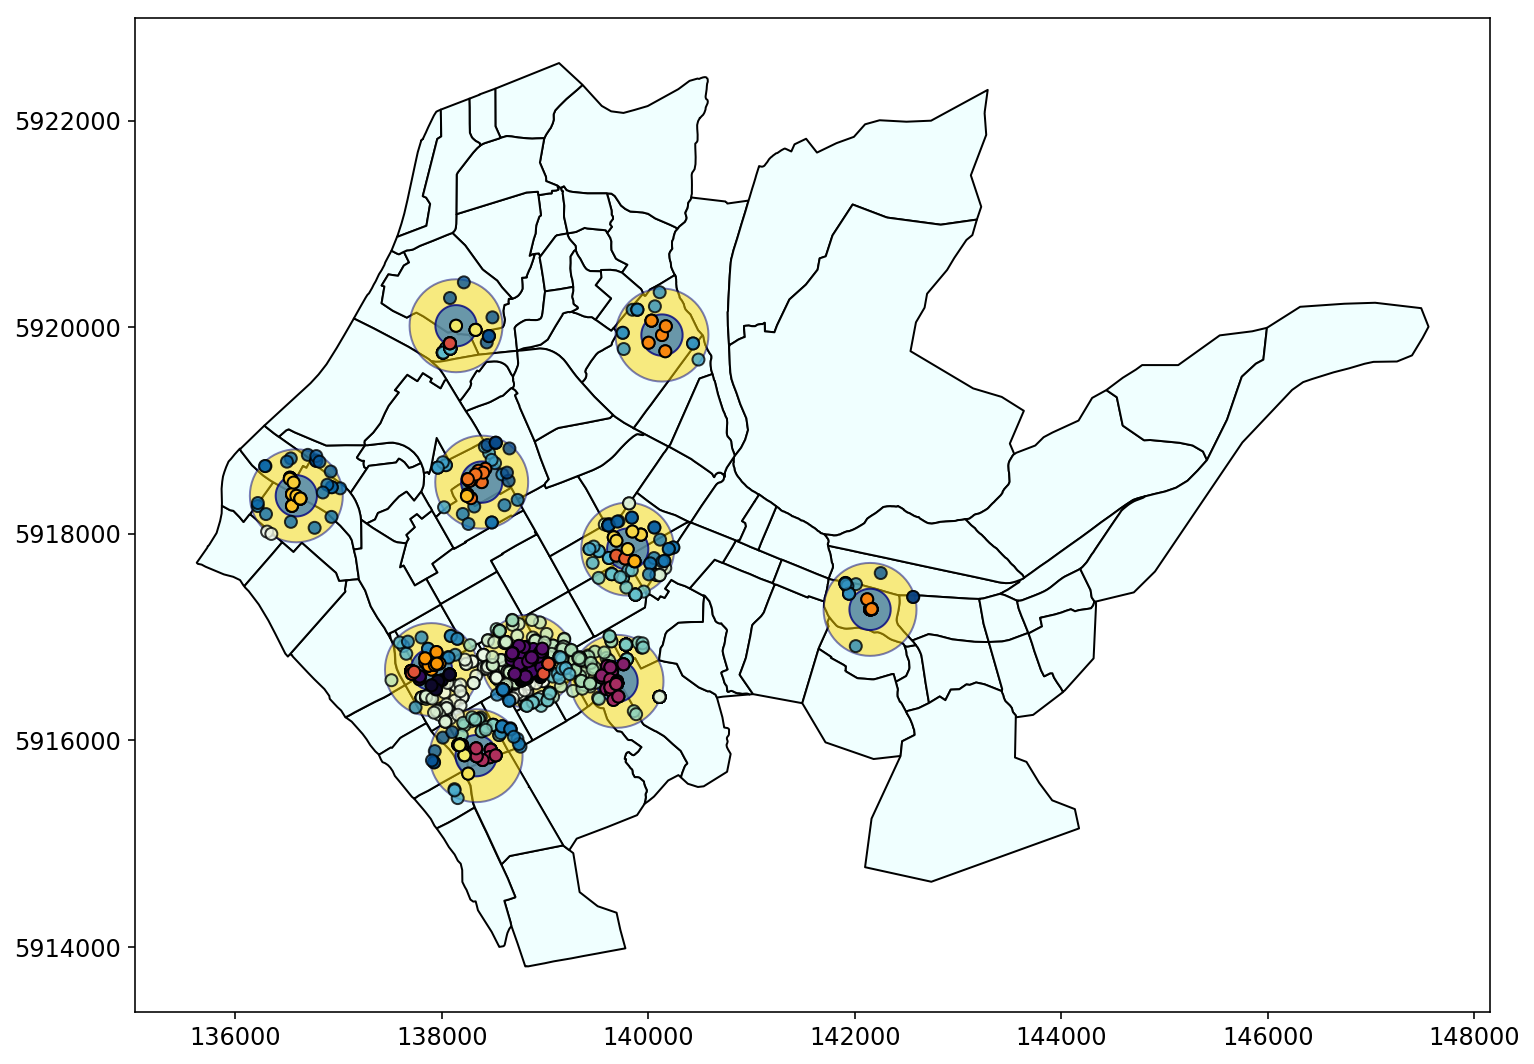

In [147]:
rep = pd.read_csv(r'C:\Users\croja\Tesiss/reporte_IN04_10nodes.csv', sep = ';', encoding='utf-8') #leer reporte generado
rep_list = rep.values.tolist() #transformar a lsita
rl=[]  #reordena lista 
for i in rep_list:
    rl.extend(i) 

HP_10 = IN04.copy()  
uu10 = pd.DataFrame() # LLamar a nodos desde dataframe de distancias
uu10= df_IN04.iloc[rl, [0, 1]] 



#Transformación del set de coordenadas en GeoDataframe
rdf_10= gpd.GeoDataFrame(uu10, geometry=gpd.points_from_xy(uu10.x, uu10.y), crs = {'init': 'epsg:32719'}) 

rdf_10 = rdf_10.to_crs({'init': 'epsg:32719'}) #asegura cambio de sistema medición a metros

radio10_0 = rdf_10.buffer(200) #radios paradas
radio10_1 = rdf_10.buffer(200).unary_union  #multipolígono paradas

radio10_2 = rdf_10.buffer(450)
radio10_3 = rdf_10.buffer(450).unary_union #multipolígono cobertura cliente como operado


paradas10_1 = HP_10['geometry'].intersection(radio10_1) # Intersección demanda con multipolígono paradas
#print( "paradas 10 nodos: ", paradas10_1)
paradas10_2 = HP_10['geometry'].intersection(radio10_3)
#print( "operador 10 nodos: ", paradas10_2) #intersección demanda con operador 

plt.figure()

ax = GC.plot(color='azure', edgecolor='black', figsize=(15,9.14))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
radio10_2.plot(ax=ax, color="gold", edgecolor="navy", figsize=(15,9.14), alpha=0.5)
radio10_0.plot(ax=ax, color="steelblue", edgecolor="navy", figsize=(15,9.14), alpha=0.8)
paradas10_2.plot(ax=ax, cmap="GnBu", figsize=(15,9.14), edgecolor='black', alpha=0.8)
paradas10_1.plot(ax=ax, cmap="inferno", figsize=(15,9.14), edgecolor='black')

uu20 = pd.DataFrame(uu20)
index_uu20 = list(uu20.index.values.astype('int64'))


plt.savefig("10nodos_IN04.png", format="png", bbox_inches="tight", dpi=300)

print(index_uu20)
plt.show()


In [142]:
Demand_Paradas_10 = HP_10[~paradas10_1.is_empty]
Demand_Paradas_10_o = HP_10[~paradas10_2.is_empty]

Cobertura_operador_10 =len(Demand_Paradas_10_o)-len(Demand_Paradas_10)

print("Puntos de demanda total: ", str(HP_10.shape[0]))
print("Puntos de demanda en el radio de paradas: " + str(Demand_Paradas_10.shape[0]))
print("Puntos de demanda en el radio cubierto por agentes: " + str(Demand_Paradas_10_o.shape[0]))
print("Operadores cubren ", str(Cobertura_operador_10), "puntos de demanda por si solos.")

print("Las paradas albergan directamente el ", round((len(Demand_Paradas_10))*100/(len(HP_10)), 2), "% de las demandas solicitadas a las 18:00 hrs.")
print("Si participan operadores mediados por un incentivo, el ", round((len(Demand_Paradas_10_o))*100/(len(HP_10)), 2), "% de las demandas solicitadas se ve cubierto a las 18:00 hrs.")
print("De este modo, solo el ", (round(100-(len(Demand_Paradas_10_o))*100/(len(HP_10)), 2)), "% de las demandas solicitadas a las 18:00 hrs queda sin atender.")





Puntos de demanda total:  1652
Puntos de demanda en el radio de paradas: 145
Puntos de demanda en el radio cubierto por agentes: 581
Operadores cubren  436 puntos de demanda por si solos.
Las paradas albergan directamente el  8.78 % de las demandas solicitadas a las 18:00 hrs.
Si participan operadores mediados por un incentivo, el  35.17 % de las demandas solicitadas se ve cubierto a las 18:00 hrs.
De este modo, solo el  64.83 % de las demandas solicitadas a las 18:00 hrs queda sin atender.


# 20 nodos

<Figure size 432x288 with 0 Axes>

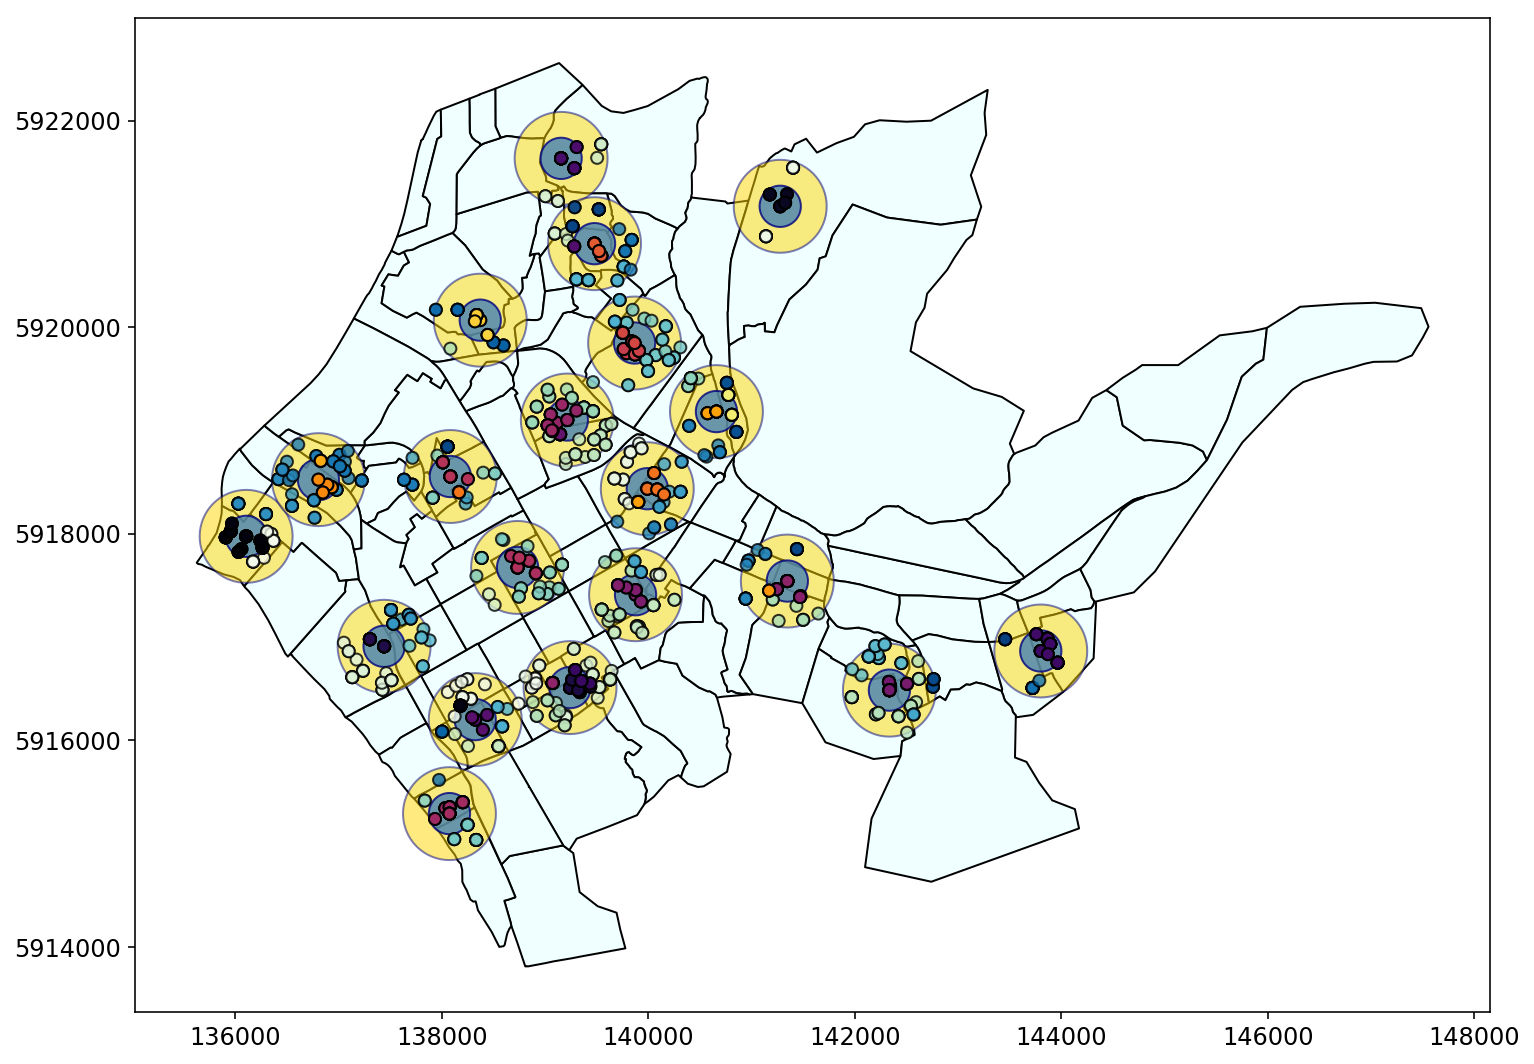

In [145]:
rep = pd.read_csv(r'C:\Users\croja\Tesiss/reporte_IN05_20nodes.csv', sep = ';', encoding='utf-8') #leer reporte generado
rep_list = rep.values.tolist() #transformar a lsita
rl=[]  #reordena lista 
for i in rep_list:
    rl.extend(i) 

HP_20 = IN05.copy()  
uu20 = pd.DataFrame() # LLamar a nodos desde dataframe de distancias
uu20= df_IN05.iloc[rl, [0, 1]] 



#Transformación del set de coordenadas en GeoDataframe
rdf_20= gpd.GeoDataFrame(uu20, geometry=gpd.points_from_xy(uu20.x, uu20.y), crs = {'init': 'epsg:32719'}) 

rdf_20 = rdf_20.to_crs({'init': 'epsg:32719'}) #asegura cambio de sistema medición a metros

radio20_0 = rdf_20.buffer(200) #radios paradas
radio20_1 = rdf_20.buffer(200).unary_union  #multipolígono paradas

radio20_2 = rdf_20.buffer(450)
radio20_3 = rdf_20.buffer(450).unary_union #multipolígono cobertura cliente como operado


paradas20_1 = HP_20['geometry'].intersection(radio20_1) # Intersección demanda con multipolígono paradas
#print( "paradas 20 nodos: ", paradas20_1)
paradas20_2 = HP_20['geometry'].intersection(radio20_3)
#print( "operador 20 nodos: ", paradas20_2) #intersección demanda con operador 

plt.figure()

ax = GC.plot(color='azure', edgecolor='black', figsize=(15,9.14))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
radio20_2.plot(ax=ax, color="gold", edgecolor="navy", figsize=(15,9.14), alpha=0.5)
radio20_0.plot(ax=ax, color="steelblue", edgecolor="navy", figsize=(15,9.14), alpha=0.8)
paradas20_2.plot(ax=ax, cmap="GnBu", figsize=(15,9.14), edgecolor='black', alpha=0.8)
paradas20_1.plot(ax=ax, cmap="inferno", figsize=(15,9.14), edgecolor='black')


plt.savefig("20nodos_IN05.png", format="png", dpi=300, bbox_inches="tight")


plt.show()

#uu20.head()


In [148]:
Demand_Paradas_20 = HP_20[~paradas20_1.is_empty]
Demand_Paradas_20_o = HP_20[~paradas20_2.is_empty]

Cobertura_operador_20 =len(Demand_Paradas_20_o)-len(Demand_Paradas_20)

print("Puntos de demanda total: ", str(HP_20.shape[0]))
print("Puntos de demanda en el radio de paradas: " + str(Demand_Paradas_20.shape[0]))
print("Puntos de demanda en el radio cubierto por agentes: " + str(Demand_Paradas_20_o.shape[0]))
print("Operadores cubren ", str(Cobertura_operador_20), "puntos de demanda por si solos.")

print("Las paradas albergan directamente el ", round((len(Demand_Paradas_20))*100/(len(HP_20)), 2), "% de las demandas solicitadas a las 18:00 hrs.")
print("Si participan operadores mediados por un incentivo, el ", round((len(Demand_Paradas_20_o))*100/(len(HP_20)), 2), "% de las demandas solicitadas se ve cubierto a las 18:00 hrs.")
print("De este modo, solo el ", (round(100-(len(Demand_Paradas_20_o))*100/(len(HP_20)), 2)), "% de las demandas solicitadas a las 18:00 hrs queda sin atender.")



Puntos de demanda total:  1652
Puntos de demanda en el radio de paradas: 337
Puntos de demanda en el radio cubierto por agentes: 1041
Operadores cubren  704 puntos de demanda por si solos.
Las paradas albergan directamente el  20.4 % de las demandas solicitadas a las 18:00 hrs.
Si participan operadores mediados por un incentivo, el  63.01 % de las demandas solicitadas se ve cubierto a las 18:00 hrs.
De este modo, solo el  36.99 % de las demandas solicitadas a las 18:00 hrs queda sin atender.


# 30 nodos

<Figure size 432x288 with 0 Axes>

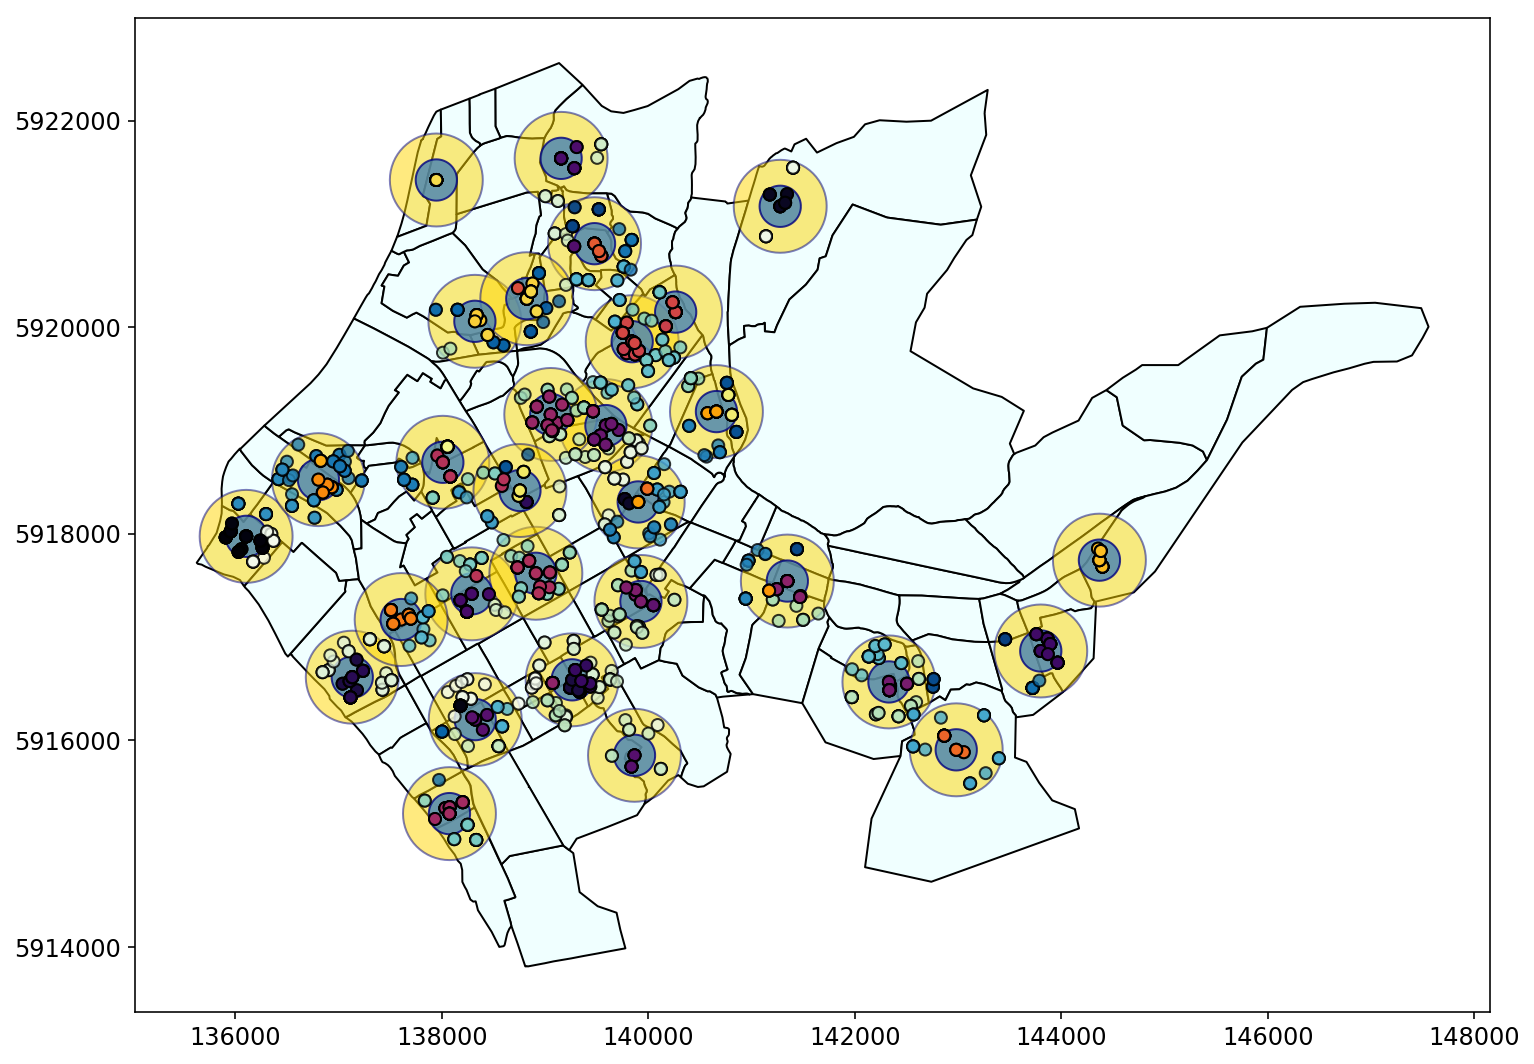

In [149]:
rep = pd.read_csv(r'C:\Users\croja\Tesiss/reporte_IN05_30nodes.csv', sep = ';', encoding='utf-8') #leer reporte generado
rep_list = rep.values.tolist() #transformar a lsita
rl=[]  #reordena lista 
for i in rep_list:
    rl.extend(i) 


uu30 = pd.DataFrame() 

uu30= df_IN05.iloc[rl, [0, 1]] 

HP_30 = IN05.copy()


#Transformación del set de coordenadas en GeoDataframe
rdf_30= gpd.GeoDataFrame(uu30, geometry=gpd.points_from_xy(uu30.x, uu30.y), crs = {'init': 'epsg:32719'}) 

rdf_30 = rdf_30.to_crs({'init': 'epsg:32719'}) #asegura cambio de sistema medición a metros

radio30_0 = rdf_30.buffer(200) #radios paradas
radio30_1 = rdf_30.buffer(200).unary_union  #multipolígono paradas

radio30_2 = rdf_30.buffer(450)
radio30_3 = rdf_30.buffer(450).unary_union #multipolígono cobertura cliente como operado


paradas30_1 = HP_30['geometry'].intersection(radio30_1) # Intersección demanda con multipológonos
paradas30_2= HP_30['geometry'].intersection(radio30_3)


plt.figure()

ax = GC.plot(color='azure', edgecolor='black', figsize=(15,9.14))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
radio30_2.plot(ax=ax, color="gold", edgecolor="navy", figsize=(15,9.14), alpha=0.5)
radio30_0.plot(ax=ax, color="steelblue", edgecolor="navy", figsize=(15,9.14), alpha=0.8)
paradas30_2.plot(ax=ax, cmap="GnBu", figsize=(15,9.14), edgecolor='black', alpha=0.8)
paradas30_1.plot(ax=ax, cmap="inferno", figsize=(15,9.14), edgecolor='black')


plt.savefig("30nodos_IN05.png", format="png", bbox_inches="tight", dpi=300)


plt.show()


In [274]:
uu20.head() #20 nodos
uu30.head() #30 nodos

x             y                                     geometry
41   139724.546447  5.920400e+06  POINT (139724.5464473391 5920399.747330818)
51   140362.848963  5.918210e+06  POINT (140362.8489632845 5918209.716178358)
99   138180.393659  5.915958e+06  POINT (138180.3936590786 5915958.365998847)
109  140080.297783  5.917603e+06   POINT (140080.297782753 5917602.604100425)
137  139287.545141  5.917338e+06  POINT (139287.5451412224 5917337.856249366)

In [150]:
Demand_Paradas_30 = HP_30[~paradas30_1.is_empty]
Demand_Paradas_30_o = HP_30[~paradas30_2.is_empty]

Cobertura_operador_30 =len(Demand_Paradas_30_o)-len(Demand_Paradas_30)

print("Puntos de demanda total: ", str(HP_30.shape[0]))
print("Puntos de demanda en el radio de paradas: " + str(Demand_Paradas_30.shape[0]))
print("Puntos de demanda en el radio cubierto por agentes: " + str(Demand_Paradas_30_o.shape[0]))
print("Operadores cubren ", str(Cobertura_operador_30), "puntos de demanda por si solos.")

print("Las paradas albergan directamente el ", round((len(Demand_Paradas_30))*100/(len(HP_30)), 2), "% de las demandas solicitadas a las 18:00 hrs.")
print("Si participan operadores mediados por un incentivo, el ", round((len(Demand_Paradas_30_o))*100/(len(HP_30)), 2), "% de las demandas solicitadas se ve cubierto a las 18:00 hrs.")
print("De este modo, solo el ", (round(100-(len(Demand_Paradas_30_o))*100/(len(HP_30)), 2)), "% de las demandas solicitadas a las 18:00 hrs queda sin atender.")





Puntos de demanda total:  1652
Puntos de demanda en el radio de paradas: 516
Puntos de demanda en el radio cubierto por agentes: 1279
Operadores cubren  763 puntos de demanda por si solos.
Las paradas albergan directamente el  31.23 % de las demandas solicitadas a las 18:00 hrs.
Si participan operadores mediados por un incentivo, el  77.42 % de las demandas solicitadas se ve cubierto a las 18:00 hrs.
De este modo, solo el  22.58 % de las demandas solicitadas a las 18:00 hrs queda sin atender.


# Modelo de cálculo para otras instancias

[36, 89, 160, 180, 274, 312, 399, 429, 557, 586, 635, 699, 720, 754, 834, 886, 1044, 1112, 1202, 1297]


<Figure size 432x288 with 0 Axes>

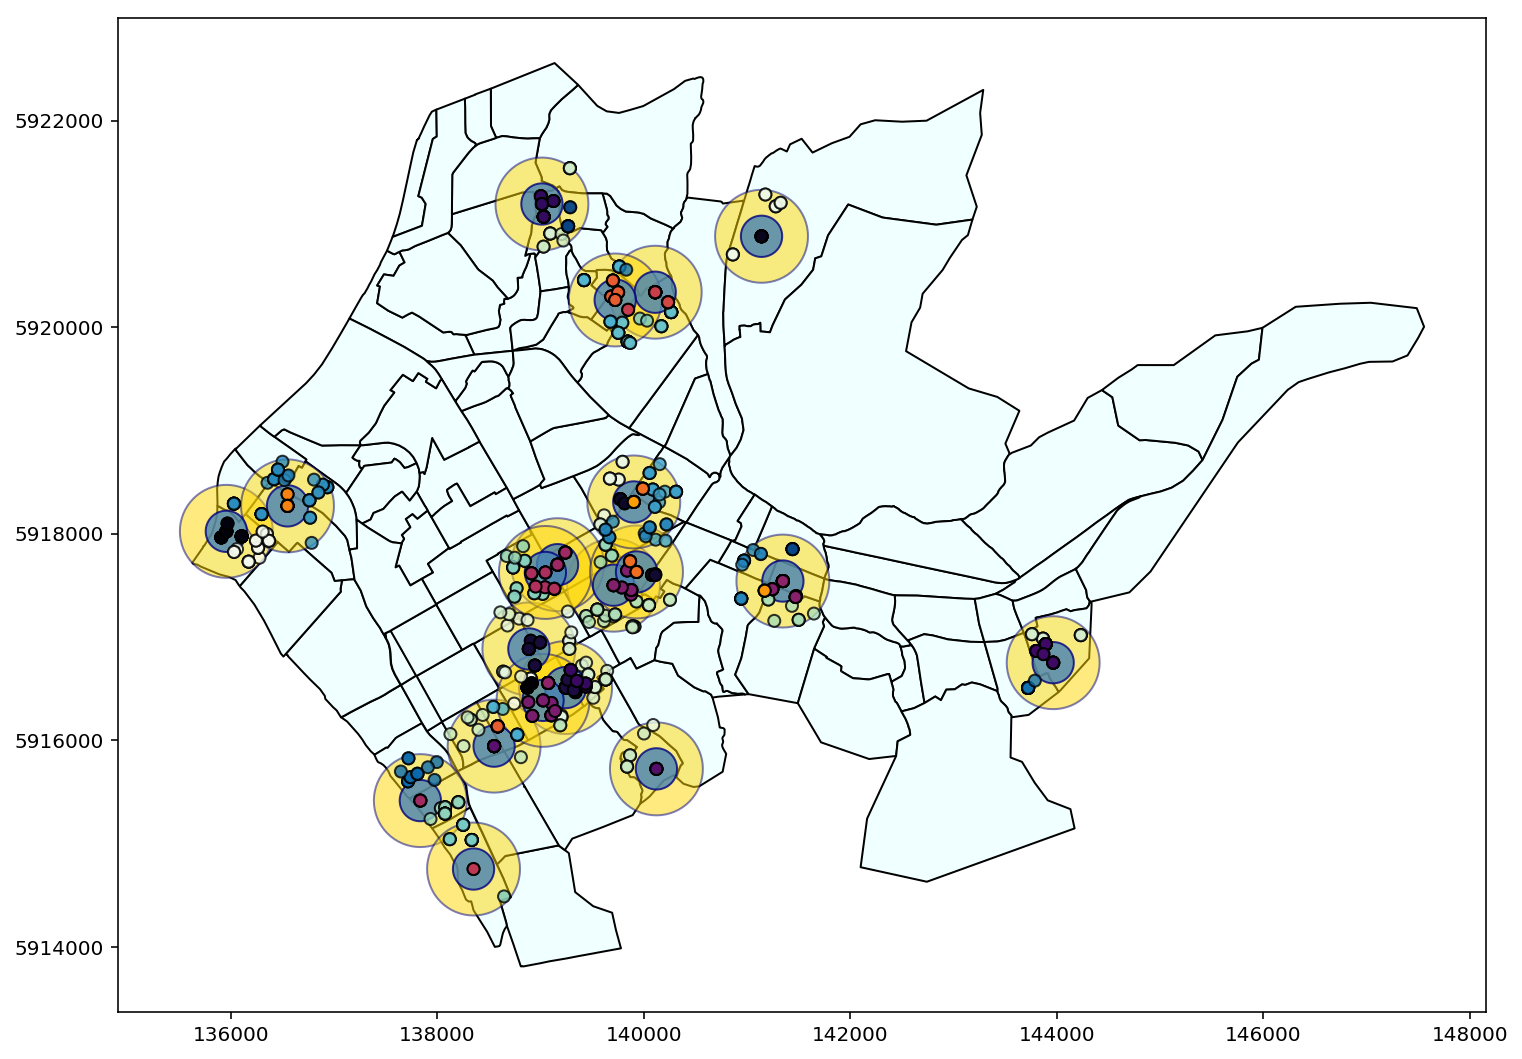

In [59]:
#para antes de las 8:00

rep = pd.read_csv(r'C:\Users\croja\Tesiss/reporte_IN05_20nodes.csv', sep = ';', encoding='utf-8') #leer reporte 
rep_list = rep.values.tolist() #transformar a lsita
rl=[]  #reordena lista 
for i in rep_list:
    rl.extend(i) 

HP_20 = IN05.copy()
uu20 = pd.DataFrame() # LLamar a nodos desde dataframe de distancias
uu20= df_IN05.iloc[rl, [0, 1]] 


#Transformación del set de coordenadas en GeoDataframe
rdf_20= gpd.GeoDataFrame(uu20, geometry=gpd.points_from_xy(uu20.x, uu20.y), crs = {'init': 'epsg:32719'}) 

rdf_20 = rdf_20.to_crs({'init': 'epsg:32719'}) #asegura cambio de sistema medición a metros

radio20_0 = rdf_20.buffer(200) #radios paradas
radio20_1 = rdf_20.buffer(200).unary_union  #multipolígono paradas

radio20_2 = rdf_20.buffer(450)
radio20_3 = rdf_20.buffer(450).unary_union #multipolígono cobertura cliente como operado


paradas20_1 = HP_20['geometry'].intersection(radio20_1) # Intersección demanda con multipolígono paradas
#print( "paradas 20 nodos: ", paradas20_1)
paradas20_2 = HP_20['geometry'].intersection(radio20_3)
#print( "operador 20 nodos: ", paradas20_2) #intersección demanda con operador 

plt.figure()

ax = GC.plot(color='azure', edgecolor='black', figsize=(15,9.14))
radio20_2.plot(ax=ax, color="gold", edgecolor="navy", figsize=(15,9.14), alpha=0.5)
radio20_0.plot(ax=ax, color="steelblue", edgecolor="navy", figsize=(15,9.14), alpha=0.8)
paradas20_2.plot(ax=ax, cmap="GnBu", figsize=(15,9.14), edgecolor='black', alpha=0.8)
paradas20_1.plot(ax=ax, cmap="inferno", figsize=(15,9.14), edgecolor='black')

uu20 = pd.DataFrame(uu20)
index_uu20 = list(uu20.index.values.astype('int64'))

'''
for x in range(len(uu20)):
    label_str = " HUB %s"%index_uu20[x]
    annot_idx = uu20.x
    arrow_tip = uu20.iloc[x,0], uu20.iloc[x,1]
    # annotation text position 
    #text_pos = annot_txt_pose[s],Y4[annot_idx]
    plt.plot(arrow_tip[0], arrow_tip[1], 'o')
    ax.text(uu20.iloc[x,0], uu20.iloc[x,1], label_str, color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    #ax.annotate(label_str, xy=arrow_tip)
'''

plt.savefig("20 nodos_Pre8.png", format="png", bbox_inches="tight", dpi=300)

print(index_uu20)
plt.show()







In [45]:
Demand_Paradas_20 = HP_20[~paradas20_1.is_empty]
Demand_Paradas_20_o = HP_20[~paradas20_2.is_empty]

Cobertura_operador_20 =len(Demand_Paradas_20_o)-len(Demand_Paradas_20)

print("Puntos de demanda total: ", str(HP_20.shape[0]))
print("Puntos de demanda en el radio de paradas: " + str(Demand_Paradas_20.shape[0]))
print("Puntos de demanda en el radio cubierto por agentes: " + str(Demand_Paradas_20_o.shape[0]))
print("Operadores cubren ", str(Cobertura_operador_20), "puntos de demanda por si solos.")

print("Las paradas albergan directamente el ", round((len(Demand_Paradas_20))*100/(len(HP_20)), 2), "% de las demandas solicitadas a las 18:00 hrs.")
print("Si participan operadores mediados por un incentivo, el ", round((len(Demand_Paradas_20_o))*100/(len(HP_20)), 2), "% de las demandas solicitadas se ve cubierto a las 18:00 hrs.")
print("De este modo, solo el ", (round(100-(len(Demand_Paradas_20_o))*100/(len(HP_20)), 2)), "% de las demandas solicitadas a las 18:00 hrs queda sin atender.")



Puntos de demanda total:  1652
Puntos de demanda en el radio de paradas: 337
Puntos de demanda en el radio cubierto por agentes: 1041
Operadores cubren  704 puntos de demanda por si solos.
Las paradas albergan directamente el  20.4 % de las demandas solicitadas a las 18:00 hrs.
Si participan operadores mediados por un incentivo, el  63.01 % de las demandas solicitadas se ve cubierto a las 18:00 hrs.
De este modo, solo el  36.99 % de las demandas solicitadas a las 18:00 hrs queda sin atender.


[65, 377, 551, 638, 756, 819, 866, 917, 1114, 1141, 1183, 1203, 1321, 1393, 1429, 1466, 1486, 1493, 1581, 1729]


<Figure size 432x288 with 0 Axes>

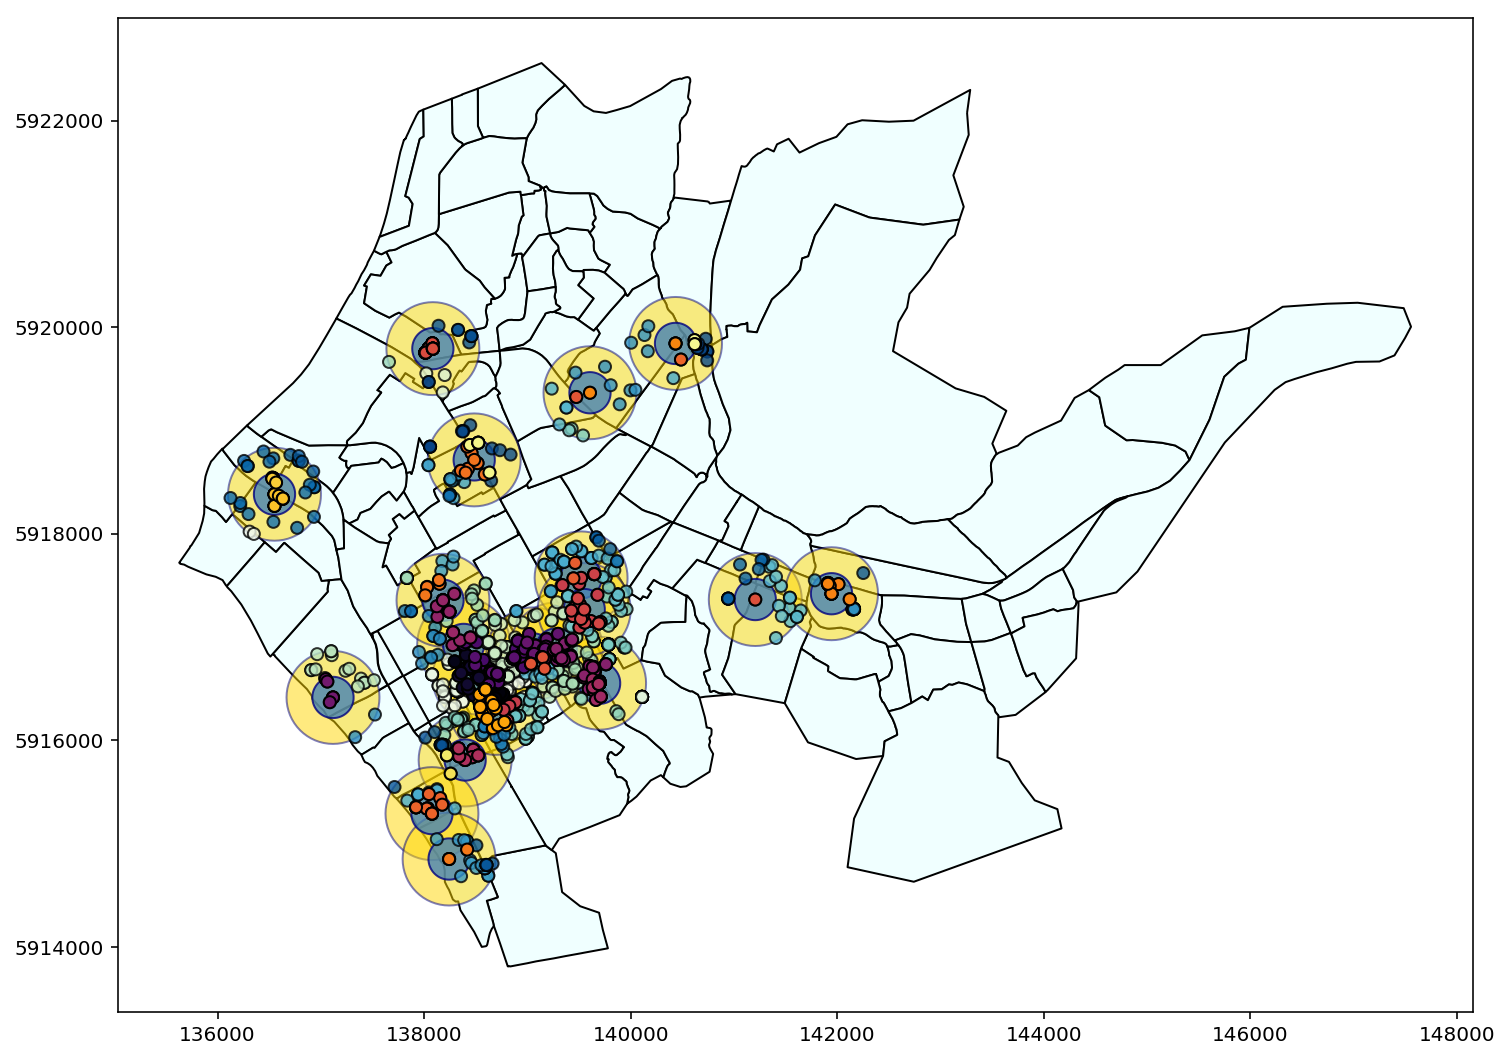

In [57]:
#para despues de las 17:00

rep = pd.read_csv(r'C:\Users\croja\Tesiss/reporte_IN04_20 nodes.csv', sep = ';', encoding='utf-8') #leer reporte 
rep_list = rep.values.tolist() #transformar a lsita
rl=[]  #reordena lista 
for i in rep_list:
    rl.extend(i) 

HP_20 = IN04.copy()
vv20 = pd.DataFrame() # LLamar a nodos desde dataframe de distancias
vv20= df_IN04.iloc[rl, [0, 1]] 


#Transformación del set de coordenadas en GeoDataframe
rdf_20= gpd.GeoDataFrame(vv20, geometry=gpd.points_from_xy(vv20.x, vv20.y), crs = {'init': 'epsg:32719'}) 

rdf_20 = rdf_20.to_crs({'init': 'epsg:32719'}) #asegura cambio de sistema medición a metros

radio20_0 = rdf_20.buffer(200) #radios paradas
radio20_1 = rdf_20.buffer(200).unary_union  #multipolígono paradas

radio20_2 = rdf_20.buffer(450)
radio20_3 = rdf_20.buffer(450).unary_union #multipolígono cobertura cliente como operado


paradas20_1 = HP_20['geometry'].intersection(radio20_1) # Intersección demanda con multipolígono paradas
#print( "paradas 20 nodos: ", paradas20_1)
paradas20_2 = HP_20['geometry'].intersection(radio20_3)
#print( "operador 20 nodos: ", paradas20_2) #intersección demanda con operador 

plt.figure()

ax = GC.plot(color='azure', edgecolor='black', figsize=(15,9.14))
radio20_2.plot(ax=ax, color="gold", edgecolor="navy", figsize=(15,9.14), alpha=0.5)
radio20_0.plot(ax=ax, color="steelblue", edgecolor="navy", figsize=(15,9.14), alpha=0.8)
paradas20_2.plot(ax=ax, cmap="GnBu", figsize=(15,9.14), edgecolor='black', alpha=0.8)
paradas20_1.plot(ax=ax, cmap="inferno", figsize=(15,9.14), edgecolor='black')

vv20 = pd.DataFrame(vv20)
index_vv20 = list(vv20.index.values.astype('int64'))

'''
for x in range(len(vv20)):
    label_str = " HUB %s"%index_vv20[x]
    annot_idx = vv20.x
    arrow_tip = vv20.iloc[x,0], vv20.iloc[x,1]
    plt.plot(arrow_tip[0], arrow_tip[1], 'o')
    ax.text(vv20.iloc[x,0], vv20.iloc[x,1], label_str, color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
'''

plt.savefig("20 nodos_Post17.png", format="png", bbox_inches="tight", dpi=300)

print(index_vv20)
plt.show()


In [58]:
Demand_Paradas_20 = HP_20[~paradas20_1.is_empty]
Demand_Paradas_20_o = HP_20[~paradas20_2.is_empty]

Cobertura_operador_20 =len(Demand_Paradas_20_o)-len(Demand_Paradas_20)

print("Puntos de demanda total: ", str(HP_20.shape[0]))
print("Puntos de demanda en el radio de paradas: " + str(Demand_Paradas_20.shape[0]))
print("Puntos de demanda en el radio cubierto por agentes: " + str(Demand_Paradas_20_o.shape[0]))
print("Operadores cubren ", str(Cobertura_operador_20), "puntos de demanda por si solos.")

print("Las paradas albergan directamente el ", round((len(Demand_Paradas_20))*100/(len(HP_20)), 2), "% de las demandas solicitadas a las 18:00 hrs.")
print("Si participan operadores mediados por un incentivo, el ", round((len(Demand_Paradas_20_o))*100/(len(HP_20)), 2), "% de las demandas solicitadas se ve cubierto a las 18:00 hrs.")
print("De este modo, solo el ", (round(100-(len(Demand_Paradas_20_o))*100/(len(HP_20)), 2)), "% de las demandas solicitadas a las 18:00 hrs queda sin atender.")




Puntos de demanda total:  2025
Puntos de demanda en el radio de paradas: 592
Puntos de demanda en el radio cubierto por agentes: 1234
Operadores cubren  642 puntos de demanda por si solos.
Las paradas albergan directamente el  29.23 % de las demandas solicitadas a las 18:00 hrs.
Si participan operadores mediados por un incentivo, el  60.94 % de las demandas solicitadas se ve cubierto a las 18:00 hrs.
De este modo, solo el  39.06 % de las demandas solicitadas a las 18:00 hrs queda sin atender.


#  Cálculo de estaciones a movilizar.

In [107]:

uu20["indexi"] = index_uu20
uu20.set_index("indexi")

mov =  ['635', '754', '886', '1297', '312', '834']

boolean_series = uu20.indexi.isin(mov)
mover = uu20[boolean_series]


vv20["indexi"] = index_vv20
vv20.set_index("indexi")

mov2 =  ['1183', '917', '756', '1203', '377', '866']
boolean_series2 = vv20.indexi.isin(mov2)
destino = vv20[boolean_series2]



mover = gpd.GeoDataFrame(mover, crs = {'init': 'epsg:32719'})
mover.drop(columns=['x', 'y'], inplace=True)

mover = mover.to_crs({"init": 'epsg:4326' })
mover['x'] = mover.geometry.centroid.x.astype(float)
mover['y'] = mover.geometry.centroid.y.astype(float)


destino = gpd.GeoDataFrame(destino, crs = {'init': 'epsg:32719'})
destino.drop(columns=['x', 'y'], inplace=True)

destino = destino.to_crs({"init": 'epsg:4326' })
destino['x'] = destino.geometry.centroid.x.astype(float)
destino['y'] = destino.geometry.centroid.y.astype(float)

mover



geometry  indexi          x  \
312   POINT (-72.99159299999999 -36.82812699999999)     312 -72.991593   
635   POINT (-73.02049400000001 -36.82003099999999)     635 -73.020494   
754           POINT (-73.046173 -36.81840900000001)     754 -73.046173   
834                   POINT (-73.055318 -36.843964)     834 -73.055318   
886           POINT (-73.03299800000001 -36.794415)     886 -73.032998   
1297           POINT (-73.03628 -36.81259699999999)    1297 -73.036280   

              y  
312  -36.828127  
635  -36.820031  
754  -36.818409  
834  -36.843964  
886  -36.794415  
1297 -36.812597

In [103]:
mover.iloc[0][-2]

-72.991593

In [154]:
distancias = []
for i in range(len(mover)):
    x1 = mover.iloc[i][-2]
    y1 = mover.iloc[i][-1]
    for j in range(len(destino)):
        x2 = destino.iloc[j][-2]
        y2 = destino.iloc[j][-1]
        #distancias.append(i)
        distancias.append(haversine(x1, y1, x2, y2))

#Guardo los cálculos de distancia en series de datos separadas.

print(distancias)
e1 = distancias[0:6]
e2 = distancias[6:12]
e3 = distancias[12:18]
e4 = distancias[18:24]
e5 = distancias[24:30]
e6 = distancias[30:36]

#onvierto a dataframe
distancias2 = pd.DataFrame([e1, e2, e3, e4, e5, e6], columns=["d1", "d2", "d3", "d4", "d5", "d6"], index=["o1", "o2", "o3", "o4", "o5", "o6"])
print( )
print(distancias2)
print( )

print(distancias2.idxmin(axis=1)) # minimo valor por fila
print( ) 
print(distancias2.idxmin(axis=0)) #minimo valor por columna
print( )
print(distancias2.describe())


[5.56, 4.67, 4.25, 5.63, 6.6, 2.82, 3.02, 2.16, 1.92, 3.41, 3.96, 0.23, 0.96, 0.78, 1.25, 1.93, 2.37, 2.17, 2.18, 2.32, 2.24, 1.06, 5.05, 3.86, 3.82, 3.55, 3.81, 4.84, 2.09, 3.17, 2.05, 1.55, 1.77, 2.92, 2.34, 1.61]

      d1    d2    d3    d4    d5    d6
o1  5.56  4.67  4.25  5.63  6.60  2.82
o2  3.02  2.16  1.92  3.41  3.96  0.23
o3  0.96  0.78  1.25  1.93  2.37  2.17
o4  2.18  2.32  2.24  1.06  5.05  3.86
o5  3.82  3.55  3.81  4.84  2.09  3.17
o6  2.05  1.55  1.77  2.92  2.34  1.61

o1    d6
o2    d6
o3    d2
o4    d4
o5    d5
o6    d2
dtype: object

d1    o3
d2    o3
d3    o3
d4    o4
d5    o5
d6    o2
dtype: object

             d1        d2        d3        d4        d5        d6
count  6.000000  6.000000  6.000000  6.000000  6.000000  6.000000
mean   2.931667  2.505000  2.540000  3.298333  3.735000  2.310000
std    1.608408  1.401439  1.205687  1.723455  1.816775  1.283604
min    0.960000  0.780000  1.250000  1.060000  2.090000  0.230000
25%    2.082500  1.702500  1.807500  2.17

In [ ]:
""" 
Las asignaciones de movilidad  y distancias a recorrer son: 

o1 - d6  -- 2.82 km
o2 - d3  -- 1.92 km
o3 - d1  -- 0.962 km
o4 - d4  -- 1.06 km
o5 - d5  -- 2.09 km
o6 - d2  -- 1.55 km

"""

#Estaciones o2, o3, o4, o6 podrían ser relocalizadas mediante usuario-operador, ahorrando 11 km si consideramos un viaje de ida-vuelta del camión
# Sin usario-operador debería recorrer 20,8 km el camión, por lo que e el mejor de los casos se reduce en un 53% la distancia a recorrer.
# 




# Grafico método exacto (CPLEX)

<Figure size 432x288 with 0 Axes>

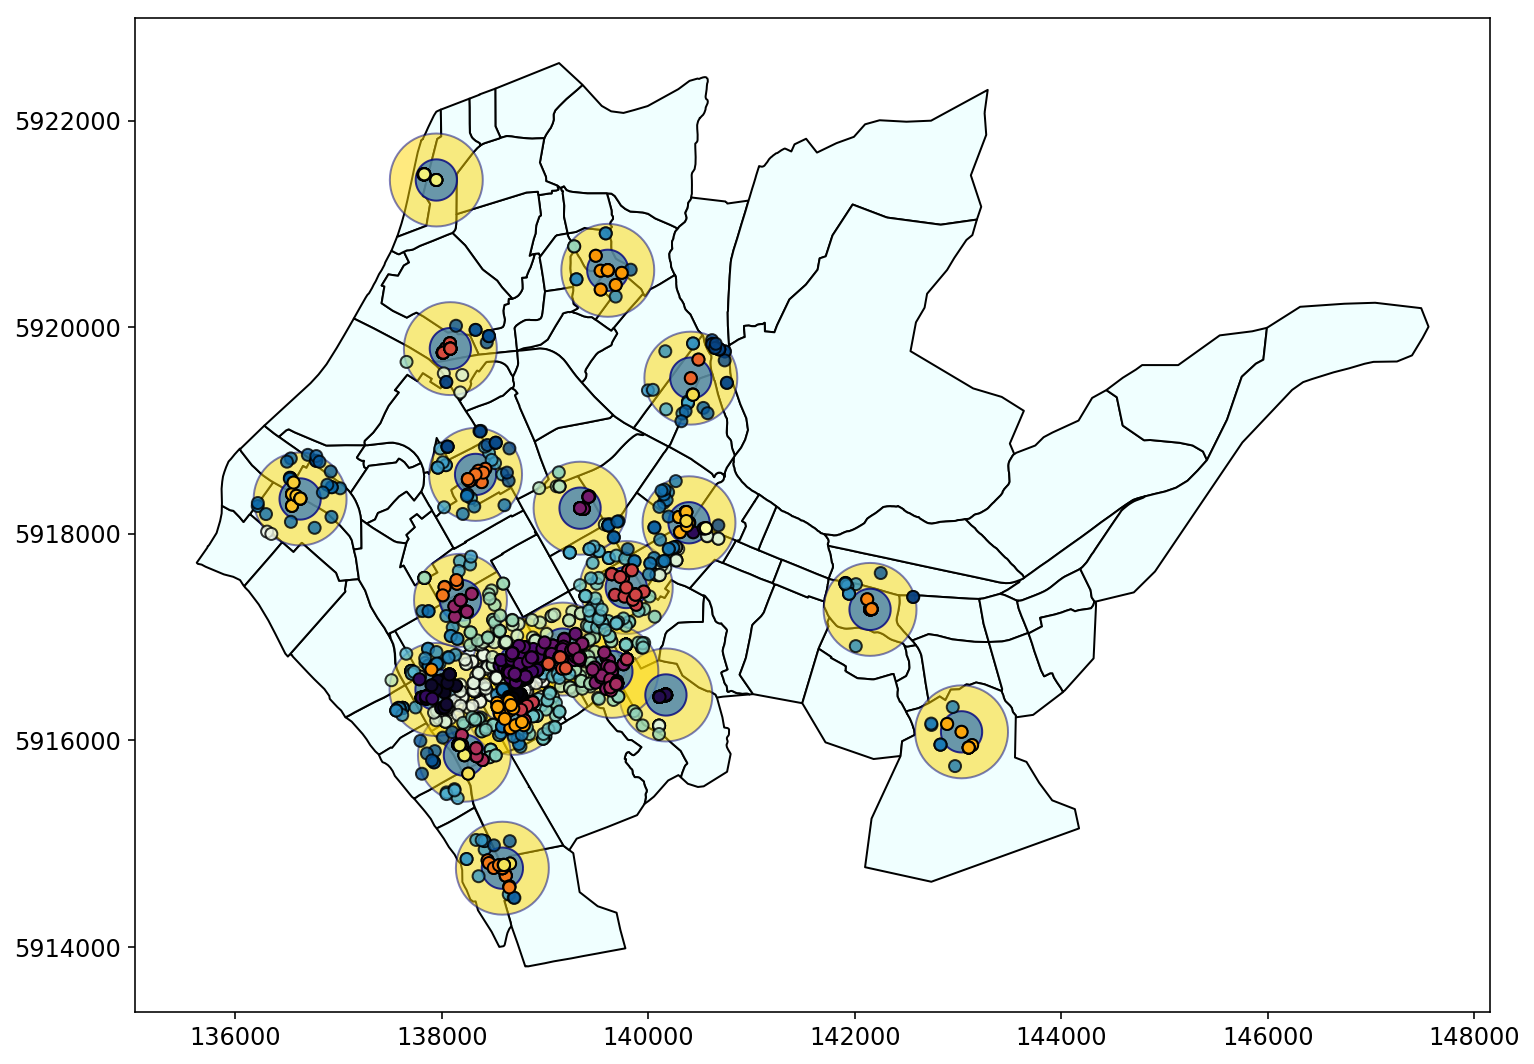

In [115]:

rl= ubicaciones_activas  #Lista resultados método exacto x Cplex


HP_20 = IN04.copy() 
uu20 = pd.DataFrame() # LLamar a nodos desde dataframe de distancias
uu20= df_IN04_2.iloc[rl, [0, 1]] 



#Transformación del set de coordenadas en GeoDataframe
rdf_20= gpd.GeoDataFrame(uu20, geometry=gpd.points_from_xy(uu20.x, uu20.y), crs = {'init': 'epsg:32719'}) 

rdf_20 = rdf_20.to_crs({'init': 'epsg:32719'}) #asegura cambio de sistema medición a metros

radio20_0 = rdf_20.buffer(200) #radios paradas
radio20_1 = rdf_20.buffer(200).unary_union  #multipolígono paradas

radio20_2 = rdf_20.buffer(450)
radio20_3 = rdf_20.buffer(450).unary_union #multipolígono cobertura cliente como operado


paradas20_1 = HP_20['geometry'].intersection(radio20_1) # Intersección demanda con multipolígono paradas
#print( "paradas 20 nodos: ", paradas20_1)
paradas20_2 = HP_20['geometry'].intersection(radio20_3)
#print( "operador 20 nodos: ", paradas20_2) #intersección demanda con operador 

plt.figure()

ax = GC.plot(color='azure', edgecolor='black', figsize=(15,9.14))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
radio20_2.plot(ax=ax, color="gold", edgecolor="navy", figsize=(15,9.14), alpha=0.5)
radio20_0.plot(ax=ax, color="steelblue", edgecolor="navy", figsize=(15,9.14), alpha=0.8)
paradas20_2.plot(ax=ax, cmap="GnBu", figsize=(15,9.14), edgecolor='black', alpha=0.8)
paradas20_1.plot(ax=ax, cmap="inferno", figsize=(15,9.14), edgecolor='black')


plt.savefig("20nodos_in04_CPLEX.png", format="png", dpi=300, bbox_inches="tight")


plt.show()

In [116]:
Demand_Paradas_20 = HP_20[~paradas20_1.is_empty]
Demand_Paradas_20_o = HP_20[~paradas20_2.is_empty]

Cobertura_operador_20 =len(Demand_Paradas_20_o)-len(Demand_Paradas_20)

print("Puntos de demanda total: ", str(HP_20.shape[0]))
print("Puntos de demanda en el radio de paradas: " + str(Demand_Paradas_20.shape[0]))
print("Puntos de demanda en el radio cubierto por agentes: " + str(Demand_Paradas_20_o.shape[0]))
print("Operadores cubren ", str(Cobertura_operador_20), "puntos de demanda por si solos.")

print("Las paradas albergan directamente el ", round((len(Demand_Paradas_20))*100/(len(HP_20)), 2), "% de las demandas solicitadas a las 18:00 hrs.")
print("Si participan operadores mediados por un incentivo, el ", round((len(Demand_Paradas_20_o))*100/(len(HP_20)), 2), "% de las demandas solicitadas se ve cubierto a las 18:00 hrs.")
print("De este modo, solo el ", (round(100-(len(Demand_Paradas_20_o))*100/(len(HP_20)), 2)), "% de las demandas solicitadas a las 18:00 hrs queda sin atender.")



Puntos de demanda total:  2025
Puntos de demanda en el radio de paradas: 725
Puntos de demanda en el radio cubierto por agentes: 1470
Operadores cubren  745 puntos de demanda por si solos.
Las paradas albergan directamente el  35.8 % de las demandas solicitadas a las 18:00 hrs.
Si participan operadores mediados por un incentivo, el  72.59 % de las demandas solicitadas se ve cubierto a las 18:00 hrs.
De este modo, solo el  27.41 % de las demandas solicitadas a las 18:00 hrs queda sin atender.


# Grafico comportamiento algoritmo


In [75]:
rep1 = pd.read_csv(r'C:\Users\croja\Tesiss/Reportes/IN01_rep.csv', sep = ';', encoding='utf-8') #leer reporte 
rep1.set_index("tiempo")

rep2 = pd.read_csv(r'C:\Users\croja\Tesiss/Reportes/IN02_rep.csv', sep = ';', encoding='utf-8') #leer reporte 
rep2.set_index("tiempo")

rep3 = pd.read_csv(r'C:\Users\croja\Tesiss/Reportes/IN03_rep.csv', sep = ';', encoding='utf-8') #leer reporte 
rep3.set_index("tiempo")


cple = pd.read_csv(r'C:\Users\croja\Tesiss/Reportes/cplex_desemp2.csv', sep = ';', encoding='utf-8') #leer reporte 
cple.set_index("tiempo")

cple.head()


tiempo     obj_20  obj_10  Obj_30
0       0  3,733,936     NaN     NaN
1       1  3,733,936     NaN     NaN
2       2  2,025,280     NaN     NaN
3       3  2,025,280     NaN     NaN
4       4  1,624,569     NaN     NaN

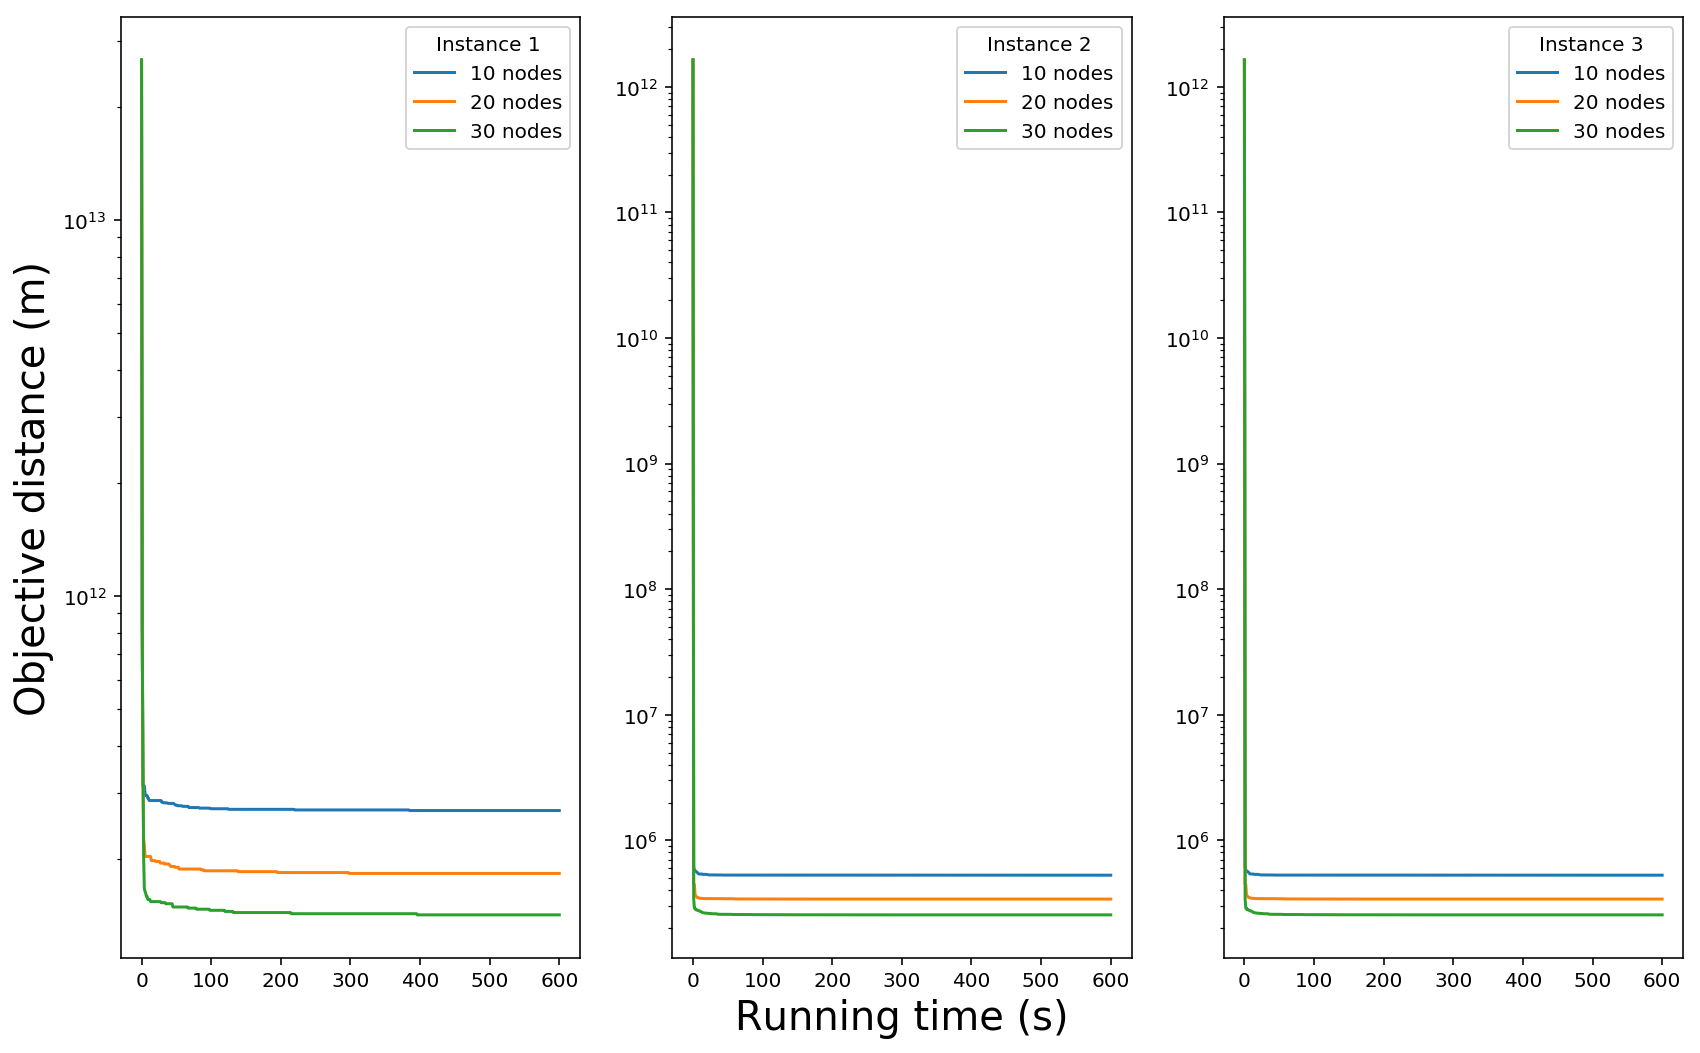

In [81]:



 
#ax.spines["top"].set_visible(False)    
#ax.spines["bottom"].set_visible(False)    
#ax.spines["right"].set_visible(False)    
#ax.spines["left"].set_visible(False) 

#plt.gca().invert_yaxis()
#plt.ylim()

f,ax= plt.subplots(figsize=(14,8.65))

x= arange(601)

IN01_10= rep1.Ob_10
IN01_20= rep1.Ob_20
IN01_30= rep1.Ob_30

IN02_10= rep2.Ob_10
IN02_20= rep2.Ob_20
IN02_30= rep2.Ob_30

IN03_10= rep3.Ob_10
IN03_20= rep3.Ob_20
IN03_30= rep3.Ob_30


subplot(131)
ax.set_xlim(-0.2,10)
p1_10, = plot(x, IN01_10, label ="10 nodes")
p1_20, = plot(x, IN01_20, label= "20 nodes")
p1_30, = plot(x, IN01_30, label= "30 nodes")
ylabel("Objective distance (m)", fontsize =20)
yscale("log")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
legend(title="Instance 1",loc="upper right", fontsize=10)

subplot(132)
ax.set_xlim(-0.2,10)
p2_10, = plot(x, IN02_10, label ="10 nodes")
p2_20, = plot(x, IN02_20, label= "20 nodes")
p2_30, = plot(x, IN02_30, label= "30 nodes")
xlabel("Running time (s)", fontsize =20)
yscale("log")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
legend(title="Instance 2", loc="upper right", fontsize=10)

subplot(133)
ax.set_xlim(-0.2,10)
p3_10, = plot(x, IN02_10, label ="10 nodes")
p3_20, = plot(x, IN02_20, label= "20 nodes")
p3_30, = plot(x, IN02_30, label= "30 nodes")
yscale("log")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
legend(title="Instance 3", loc="upper right", fontsize=10)






plt.savefig("Desempeno.png", bbox_inches="tight", dpi=300) 


show()

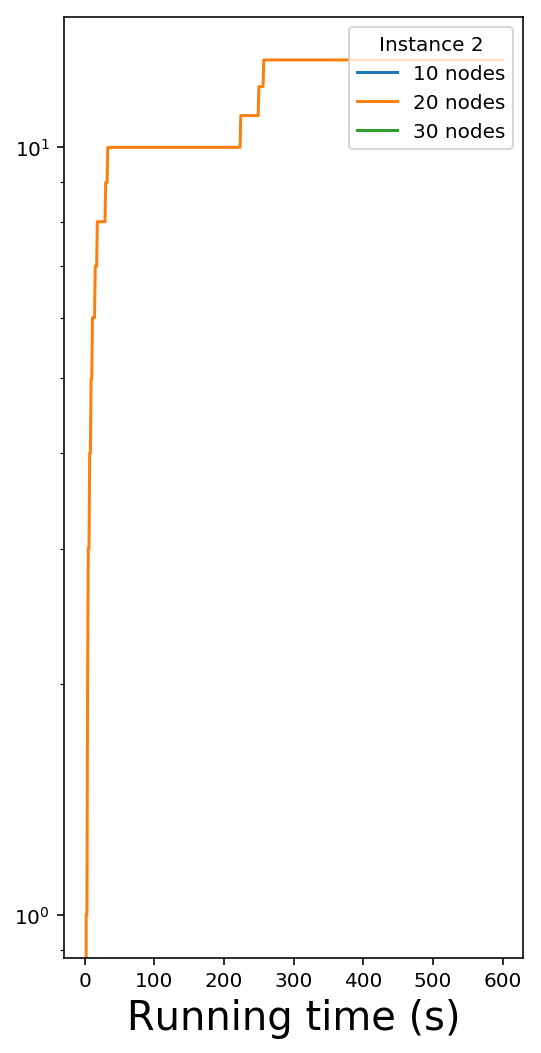

In [79]:
f,ax= plt.subplots(figsize=(14,8.65))
plt.gca().invert_yaxis()

x= arange(601)

#IN01_10= rep1.Ob_10
#IN01_20= rep1.Ob_20
#IN01_30= rep1.Ob_30

IN02_10= cple.obj_10
IN02_20= cple.obj_20
IN02_30= cple.Obj_30

#IN03_10= rep3.Ob_10
#IN03_20= rep3.Ob_20
#IN03_30= rep3.Ob_30



"""
subplot(131)
ax.set_xlim(-0.2,10)
p1_10, = plot(x, IN01_10, label ="10 nodes")
p1_20, = plot(x, IN01_20, label= "20 nodes")
p1_30, = plot(x, IN01_30, label= "30 nodes")
ylabel("Objective distance (m)", fontsize =20)
yscale("log")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
legend(title="Instance 1",loc="upper right", fontsize=10)
"""

subplot(132)
ax.set_xlim(-0.2,10)
p2_10, = plot(x, IN02_10, label ="10 nodes")
p2_20, = plot(x, IN02_20, label= "20 nodes")
p2_30, = plot(x, IN02_30, label= "30 nodes")
xlabel("Running time (s)", fontsize =20)
yscale("log")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
legend(title="Instance 2", loc="upper right", fontsize=10)

"""
subplot(133)
ax.set_xlim(-0.2,10)
p3_10, = plot(x, IN02_10, label ="10 nodes")
p3_20, = plot(x, IN02_20, label= "20 nodes")
p3_30, = plot(x, IN02_30, label= "30 nodes")
yscale("log")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
legend(title="Instance 3", loc="upper right", fontsize=10)
"""





plt.savefig("Desempeno_Cplex.png", bbox_inches="tight", dpi=300) 

